# Is Warren Buffet's Portfolio Choice Optimal?

## 1. Introduction

Warren Buffet is the world's most prominent value investor. We decided to analyze his portfolio to see if there were any improvements to be made. We loosely make use of the work of:
- Michael Pinelis and David Ruppert (Machine learning portfolio allocation(2021))
-  Shihao Gu, Bryan Kelly, and Dacheng Xiu (Empirical Asset Pricing via Machine
 Learning(2019))

In [220]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import base64
from IPython.display import Image, display
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import cvxpy as cp
from sklearn.model_selection import GridSearchCV

In [221]:
BuffetPortfolioOverview = pd.read_csv("Warren Buffet Portfolio Overview.csv")
BuffetPortfolioOverview

,Company,Ticker,"Market value as of 31 March, 2024",Number of shares,% of total portfolio
0,APPLE INC (COM),AAPL,"135,360,902,000","789,368,450",40.81%
1,BANK OF AMERICA CORP (COM),BAC,"39,165,748,000","1,032,852,006",11.81%
2,AMERICAN EXPRESS CO (COM),AXP,"34,520,240,000","151,610,700",10.41%
3,COCA COLA CO (COM),KO,"24,472,000,000","400,000,000",7.38%
4,CHEVRON CORP (COM),CVX,"19,398,898,000","122,980,207",5.85%
5,OCCIDENTAL PETROLEUM (COM),OXY,"16,118,698,000","248,018,128",4.86%
6,KRAFT HEINZ CO (COM),KHC,"12,015,925,000","325,634,818",3.62%
7,MOODYS CORP (COM),MCO,"9,695,962,000","24,669,778",2.92%
8,CHUBB LIMITED (COM),CB,"6,717,645,000","25,923,840",2.03%
9,DAVITA HEALTHCARE PARTNERS (COM),DVA,"4,982,993,000","36,095,570",1.50%


## 2. Research Method

The image below provides an overview of how we plan to proceed with our analysis.

In [222]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""
graph TD
    subgraph "Data Processing"
        A[Raw Data] --> B[Missing Value Imputation]
        B --> C[Normalization]
    end

    subgraph "Feature Engineering"
        D[Features] --> E[Fundamental Features]
        D --> F[Technical Features]
        D --> G[Sentiment Features]
    end
    
    E --> H[RF Model Training]
    F --> H
    G --> H
		
    subgraph "Training"
        H[RF Model Training] --> I[Hyperparameter Optimization]
        I --> J[Optimal Model]
    end

    subgraph "Prediction"
        K[Test Data] --> L[Return Ratio Prediction]
    end

    subgraph "Investment Strategy"
        M[Investment Strategy] --> N[Stock Selection]
        N --> O[Investment Portfolio Return & Std]
    end

    subgraph "Evaluation"
        P[Evaluation Method] --> Q[Sharpe Ratio]
    end

    C --> D
    J --> L
    L --> N
    O --> Q
""")

## 3. Data Processing

to find more details about data preprocessing and feature engineering, please see 01_data_preprocessing.ipynb 

In [223]:
financial_ratios = pd.read_csv("2014-2024 Buffet Portfolio - financial ratios.csv")
financial_ratios.describe()

,gvkey,permno,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,pay_turn,sale_invcap,sale_equity,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing
count,4711.000000,4711.000000,4642.000000,4397.000000,4701.000000,4640.000000,4640.000000,4640.000000,4640.000000,4701.000000,...,4521.000000,4696.000000,4375.000000,2479.000000,4701.000000,4701.000000,4701.000000,4680.000000,4397.000000,3051.000000
mean,40526.249629,52176.914031,29.878632,0.603942,12.443296,12.870193,13.309260,16.051649,17.033933,3.696466,...,8.888087,1.292531,3.418766,14.165560,0.015078,0.020006,0.071173,-0.041818,5.523823,1.640502
std,58402.993987,29634.292265,137.151234,0.508289,127.622422,53.446141,53.375605,82.607543,82.795749,6.762963,...,12.296629,2.200181,9.041726,43.464448,0.044623,0.028905,0.124070,0.058970,9.266644,5.971164
min,1447.000000,11308.000000,-2615.300000,0.003000,-4544.900000,-714.520000,-714.520000,-2125.000000,-2125.000000,0.062000,...,-0.233000,0.113000,0.120000,-172.250000,0.000000,0.000000,0.000000,-0.267000,0.222000,-77.522000
25%,6239.000000,16678.000000,11.699750,0.199000,9.098000,9.100500,9.259250,8.402750,8.348750,1.190000,...,1.741000,0.383000,0.672500,2.986500,0.000000,0.000000,0.000000,-0.071000,1.076000,0.188000
50%,12459.000000,56223.000000,20.942000,0.466000,12.573000,15.622500,15.936000,16.173500,15.949500,1.888000,...,4.070000,0.715000,1.396000,6.415000,0.000000,0.006000,0.000000,-0.036000,2.175000,0.616000
75%,61483.000000,81055.000000,35.358500,0.928000,17.987000,24.894000,25.753750,27.509250,27.724250,3.906000,...,10.905000,1.235250,2.573000,12.497000,0.004000,0.032000,0.148000,-0.012000,5.232000,1.449000
max,339965.000000,92611.000000,1447.000000,3.614000,1223.880000,478.000000,490.500000,758.328000,774.000000,126.556000,...,77.108000,44.562000,152.413000,977.032000,0.465000,0.204000,0.905000,0.757000,64.657000,63.498000


In [224]:
stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")
stock.describe()

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_2772/244833115.py:1: DtypeWarning: Columns (5,9,22,49,57) have mixed types. Specify dtype option on import or set low_memory=False.
  stock = pd.read_csv("2014-2024 Buffet Portfolio - stock.csv")


,PERMNO,SHRCD,EXCHCD,NAICS,PERMCO,ISSUNO,HEXCD,HSICCD,DLAMT,DLSTCD,...,SHROUT,CFACPR,CFACSHR,OPENPRC,NUMTRD,vwretd,vwretx,ewretd,ewretx,sprtrn
count,89589.000000,89589.000000,89589.000000,89563.000000,89589.000000,89589.000000,89589.000000,89589.000000,44.000000,44.000000,...,8.958300e+04,89583.000000,89583.000000,89583.000000,2.639500e+04,89589.000000,89589.000000,89589.000000,89589.000000,89589.000000
mean,49773.033832,15.129893,1.757973,464534.521733,29650.113954,16938.273159,1.801505,5891.083269,6.538636,115.250000,...,1.314680e+06,1.576633,1.546429,227.541278,7.267247e+04,0.000449,0.000371,0.000343,0.000261,0.000439
std,30343.528813,14.497378,1.053536,110869.404027,17500.224502,29921.136917,1.062598,2302.737062,23.420962,43.099736,...,2.443694e+06,3.051686,3.055253,635.758014,1.557989e+05,0.011025,0.011024,0.010709,0.010710,0.011170
min,11308.000000,11.000000,1.000000,211111.000000,7.000000,0.000000,1.000000,1311.000000,0.000000,100.000000,...,3.179000e+03,0.904200,0.250000,3.050000,0.000000e+00,-0.118168,-0.118218,-0.107631,-0.107768,-0.119841
25%,15998.000000,11.000000,1.000000,423990.000000,20440.000000,0.000000,1.000000,4832.000000,0.000000,100.000000,...,1.845000e+05,1.000000,1.000000,37.475000,7.672000e+03,-0.003923,-0.003978,-0.004576,-0.004659,-0.003812
50%,56223.000000,11.000000,1.000000,517210.000000,21299.000000,0.000000,1.000000,6029.000000,0.000000,100.000000,...,4.387400e+05,1.000000,1.000000,76.660000,2.055000e+04,0.000668,0.000550,0.000709,0.000623,0.000597
75%,80924.000000,11.000000,3.000000,524130.000000,50700.000000,20733.000000,3.000000,7370.000000,0.000000,100.000000,...,1.045085e+06,1.000000,1.000000,163.519995,5.295650e+04,0.005631,0.005565,0.005748,0.005679,0.005690
max,92611.000000,73.000000,4.000000,721110.000000,59045.000000,89707.000000,4.000000,9999.000000,128.769990,241.000000,...,1.710254e+07,28.000000,28.000000,7028.500000,2.970000e+06,0.091556,0.091477,0.082175,0.082032,0.093828


Merged data was created with the combination of the financial ratios, stock ratios and a few macroeconomic predictors as indicated by Gu et al. Here we simply present the cleaned data as the merge process was lengthy, and laborious.

In [225]:
merged_data = pd.read_csv('final_data_after_missing_value_handle_with_better_features.csv')
merged_data = merged_data.drop(merged_data.columns[1], axis=1)
# merged_data.set_index(['date', 'TICKER'], inplace=True)
merged_data.sort_index(inplace=True)

merged_data.head()

,date,TICKER,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,...,Rel_to_high,SUV,TB3MS,T10Y2Y,BAA10Y,BM,ME,Size,Momentum,ShortTermReversal
0,2014-01-31,AAPL,17.588,0.327,7.993,12.506,12.594,12.594,12.594,2.613,...,1.0,0.637808,0.04,2.464286,2.334762,0.327,4.465297e+08,19.917016,-0.007153,0.001637
1,2014-02-28,AAPL,18.776,0.296,7.764,0.463,0.466,0.466,0.466,2.698,...,1.0,0.896188,0.05,2.382632,2.390000,0.296,4.694003e+08,19.966966,-0.007153,0.001637
2,2014-03-31,AAPL,18.501,0.296,7.764,0.472,0.475,0.475,0.475,2.658,...,1.0,-1.483970,0.05,2.324286,2.340952,0.296,4.625330e+08,19.952228,-0.007153,-0.002710
3,2014-04-30,AAPL,20.332,0.296,7.764,0.519,0.523,0.523,0.523,2.921,...,1.0,1.135201,0.03,2.288095,2.199048,0.296,5.082923e+08,20.046567,-0.007153,-0.000224
4,2014-05-31,AAPL,20.513,0.302,7.873,0.537,0.540,0.540,0.540,3.097,...,1.0,2.471836,0.03,2.170000,2.203810,0.302,5.452542e+08,20.116763,-0.007153,-0.003782


# 4. Descriptive Analysis

In this section we explore various features of our data set. We can see that price is highly variable over time. In the correlation matrix we see that the price ratios related to shareholder dividends, income and operating expenses were the most highly correlated. For the most part, stock market returns were 0 and most companies had a negligible market size.

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


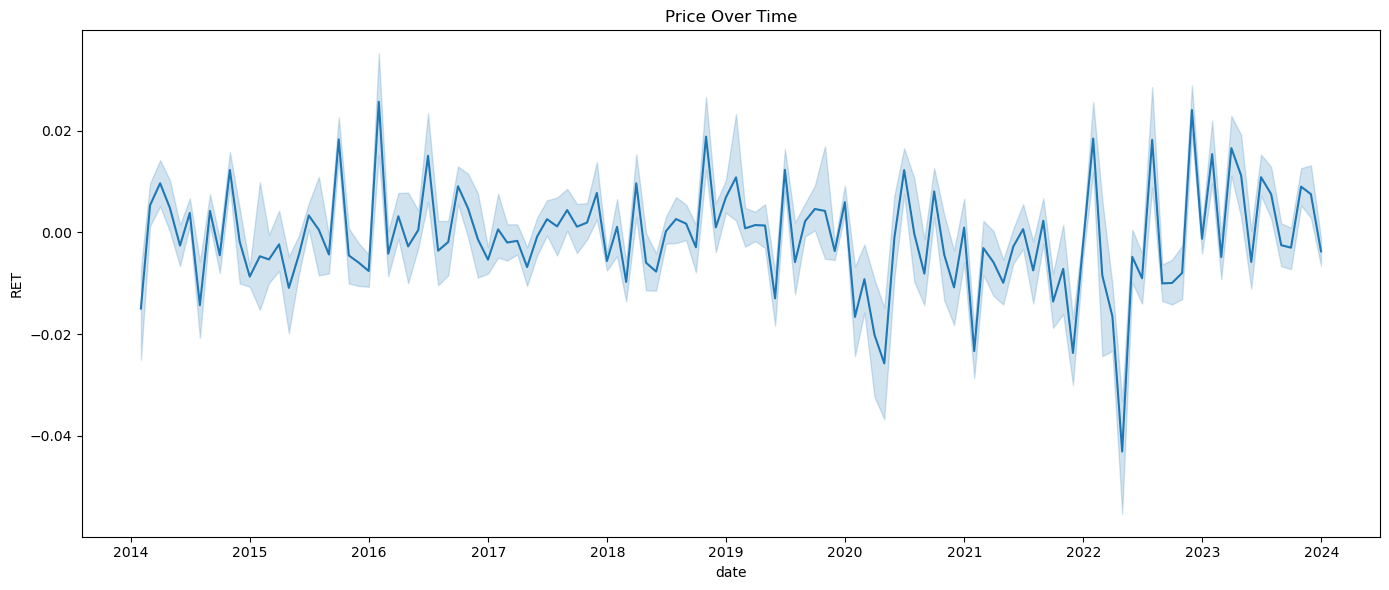

In [226]:
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Basic statistical description
statistical_description = merged_data.describe()

# Plotting the trends of a few selected metrics over time
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(14, 6))

# Plotting RET
sns.lineplot(x='date', y='RET', data=merged_data).set_title('Price Over Time')

plt.tight_layout()
plt.show()

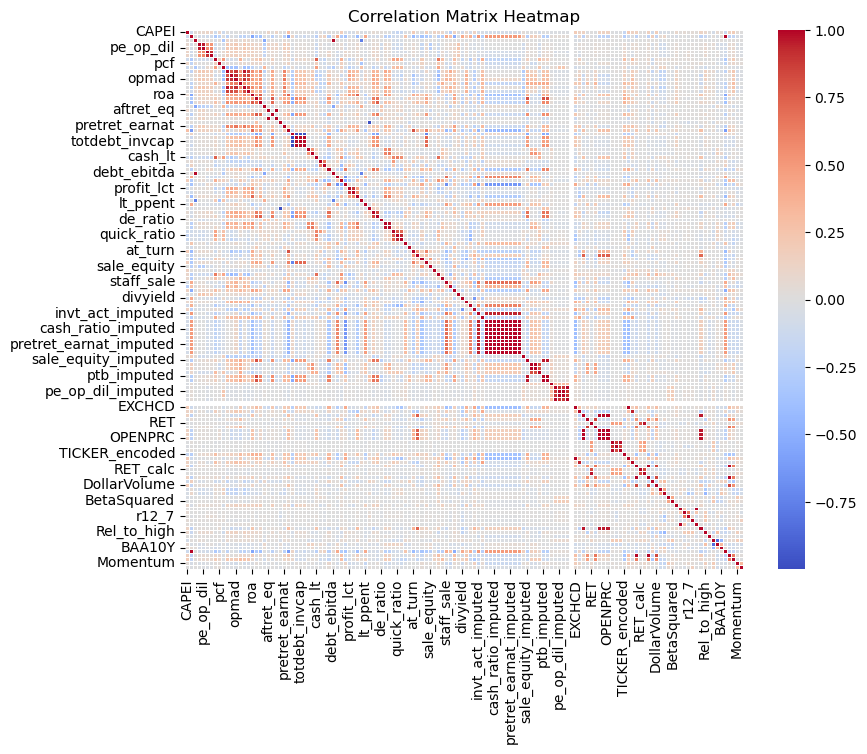

<Figure size 640x480 with 0 Axes>

In [227]:
# Recalculate the correlation matrix
correlation_matrix = merged_data.select_dtypes(include=['number']).drop(columns = 'SHRCD_encoded').corr()

# Set up the matplotlib figure
plt.figure(figsize=(9, 7))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=False, fmt=".1f", linewidths=.5, cmap="coolwarm")
plt.title('Correlation Matrix Heatmap')
plt.show()
plt.savefig('Correlation_matrix_heatmap.png')


/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_2772/980479959.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)


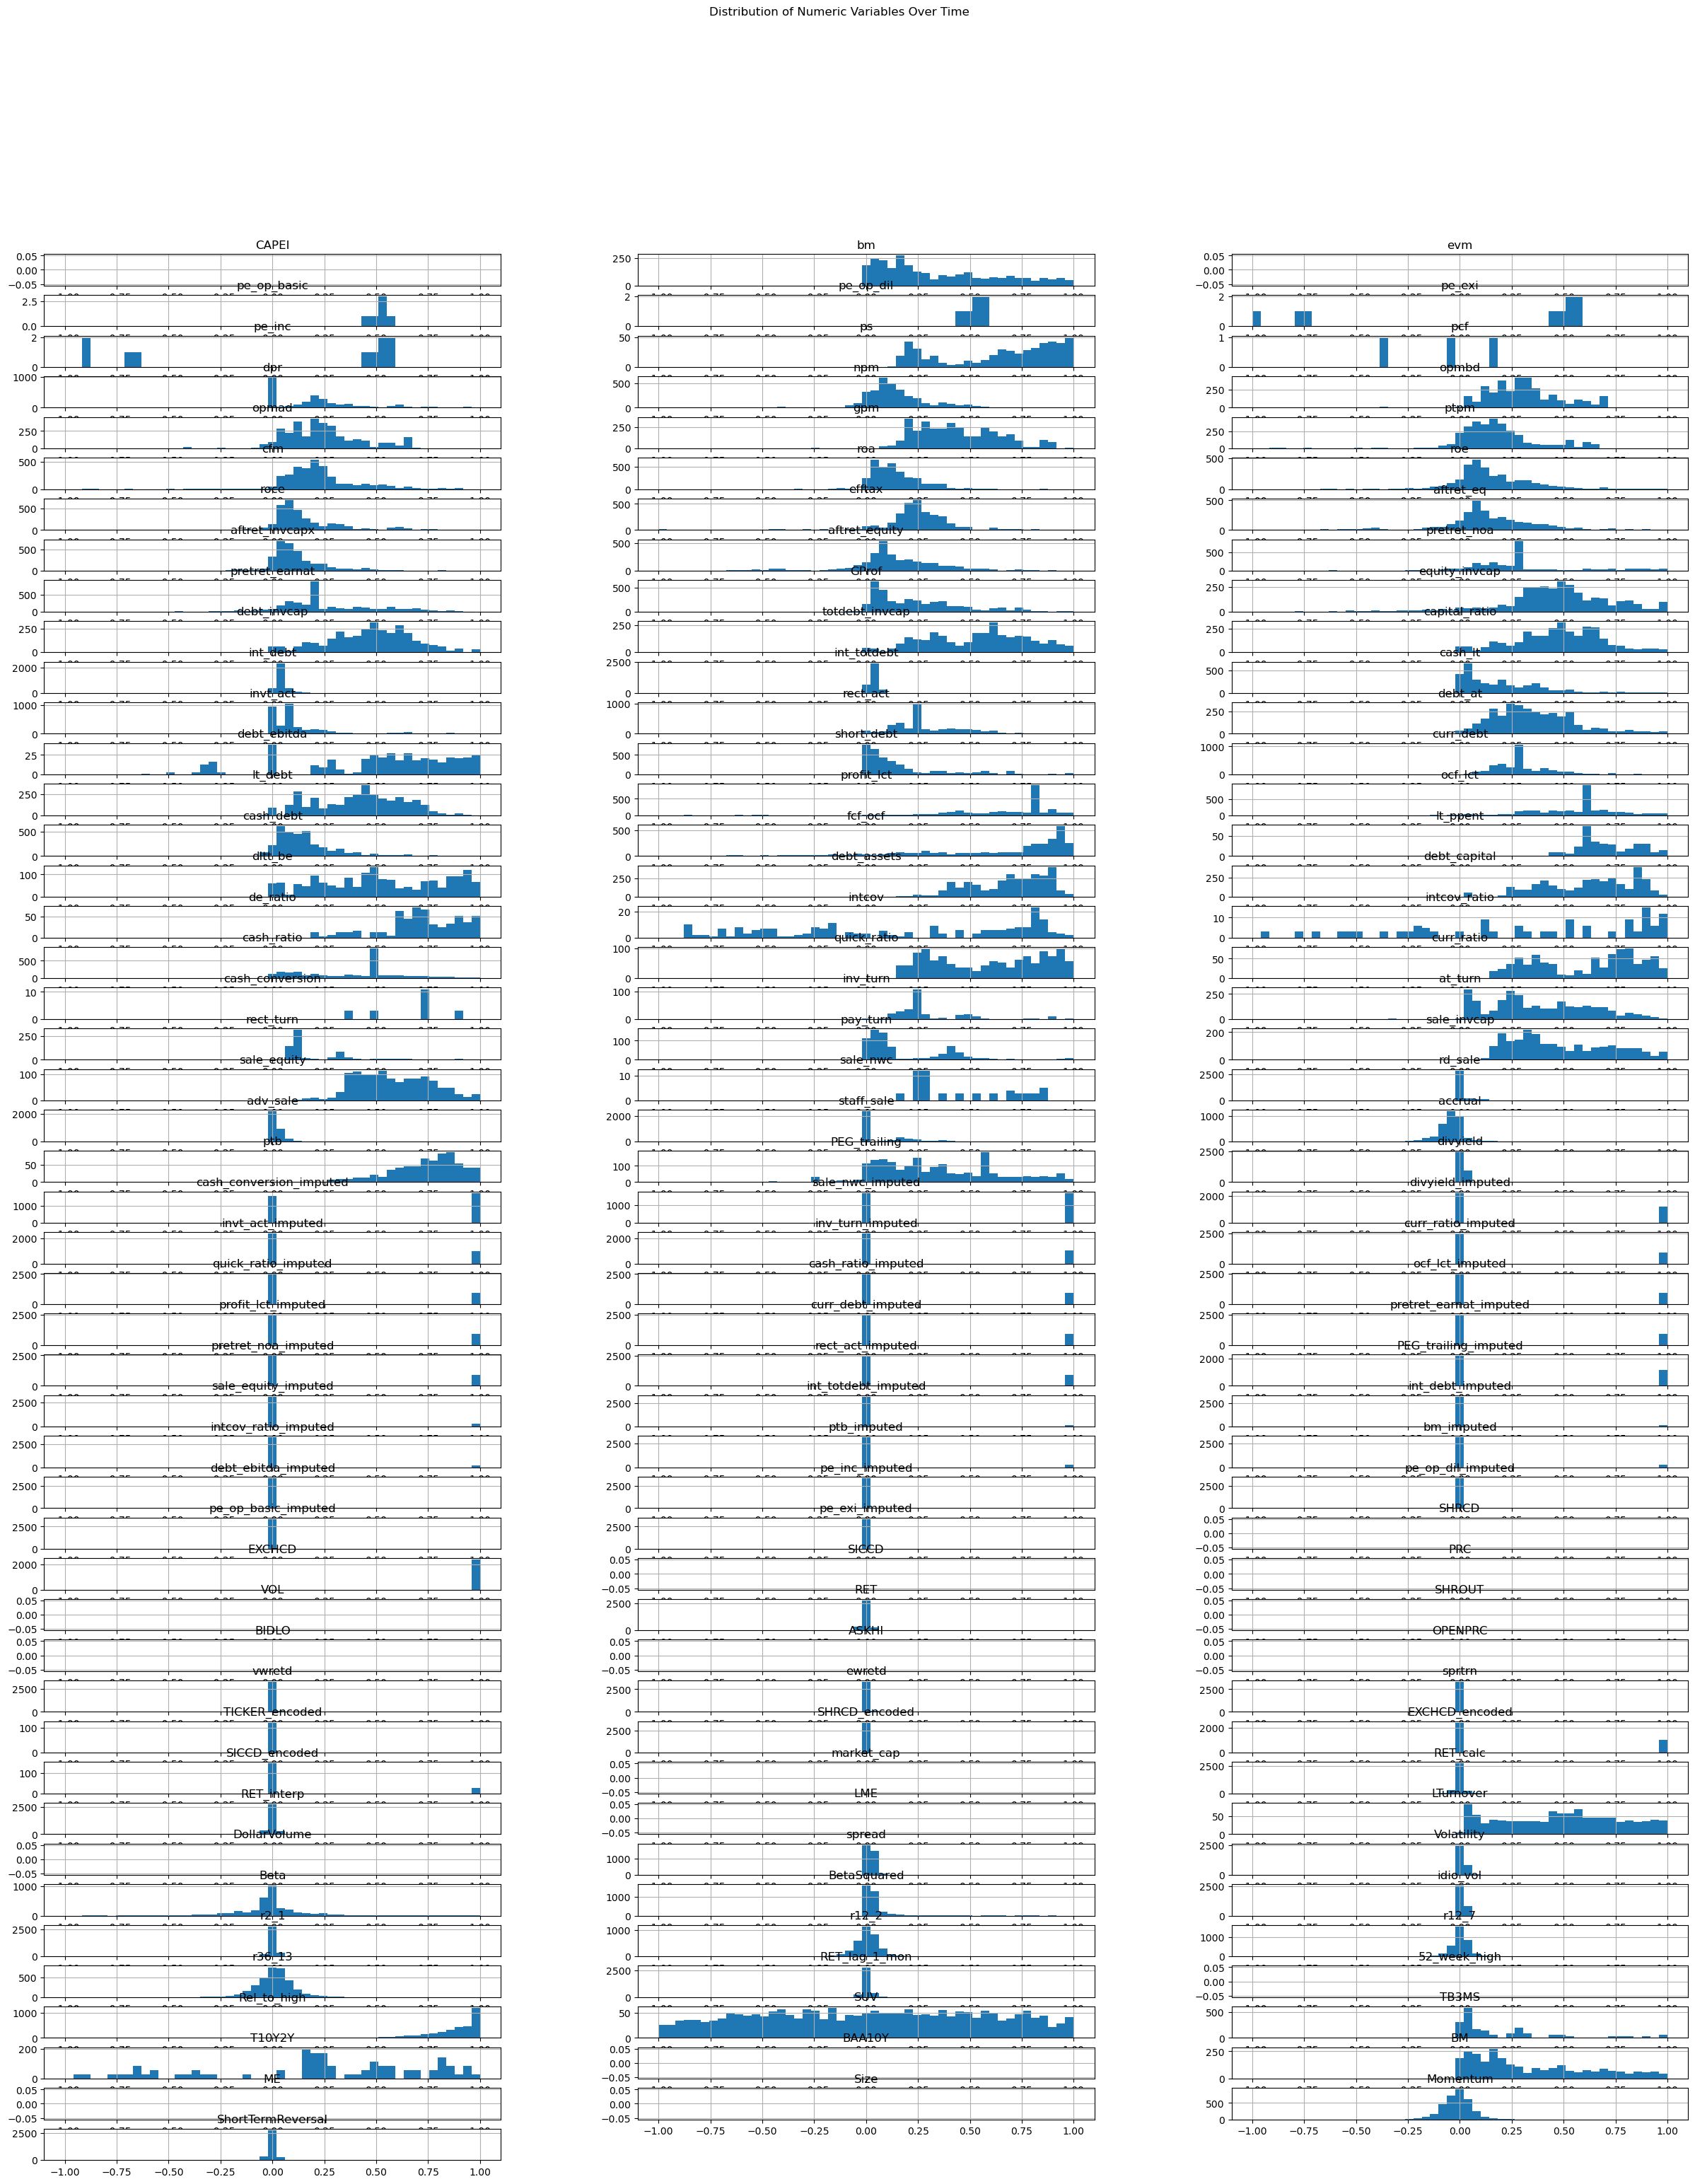

In [228]:
# Filter out non-numeric columns from merged_data
numeric_data = merged_data.select_dtypes(include=[np.number])

# Create a figure and axis object
fig, ax = plt.subplots()

# Set the figure height and width
fig.set_figheight(35)
fig.set_figwidth(30)

# Plot histograms for the numeric columns in numeric_data
numeric_data.hist(layout=(-1, 3), bins=np.linspace(-1,1,50), ax=ax)

# Set the title for the figure
fig.suptitle('Distribution of Numeric Variables Over Time')

# Save the figure as 'numbers_over_time.png'
plt.savefig('Distribution_of_Numeric_Variables_Over_Time.png')

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


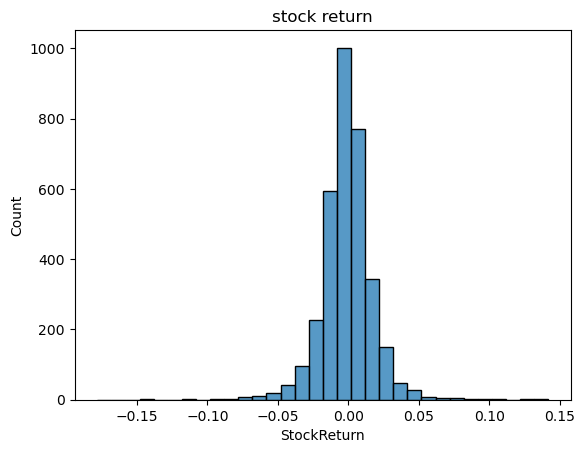

In [229]:
df_3 = merged_data[["RET"]]
df_3 = df_3.rename(columns={'RET': 'StockReturn'})
sns.histplot(data = df_3, x ="StockReturn", binwidth = 0.01, binrange = (df_3["StockReturn"].min()+ 0.00000000001, df_3["StockReturn"].max()- 0.01))
plt.title('stock return')
plt.show()

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


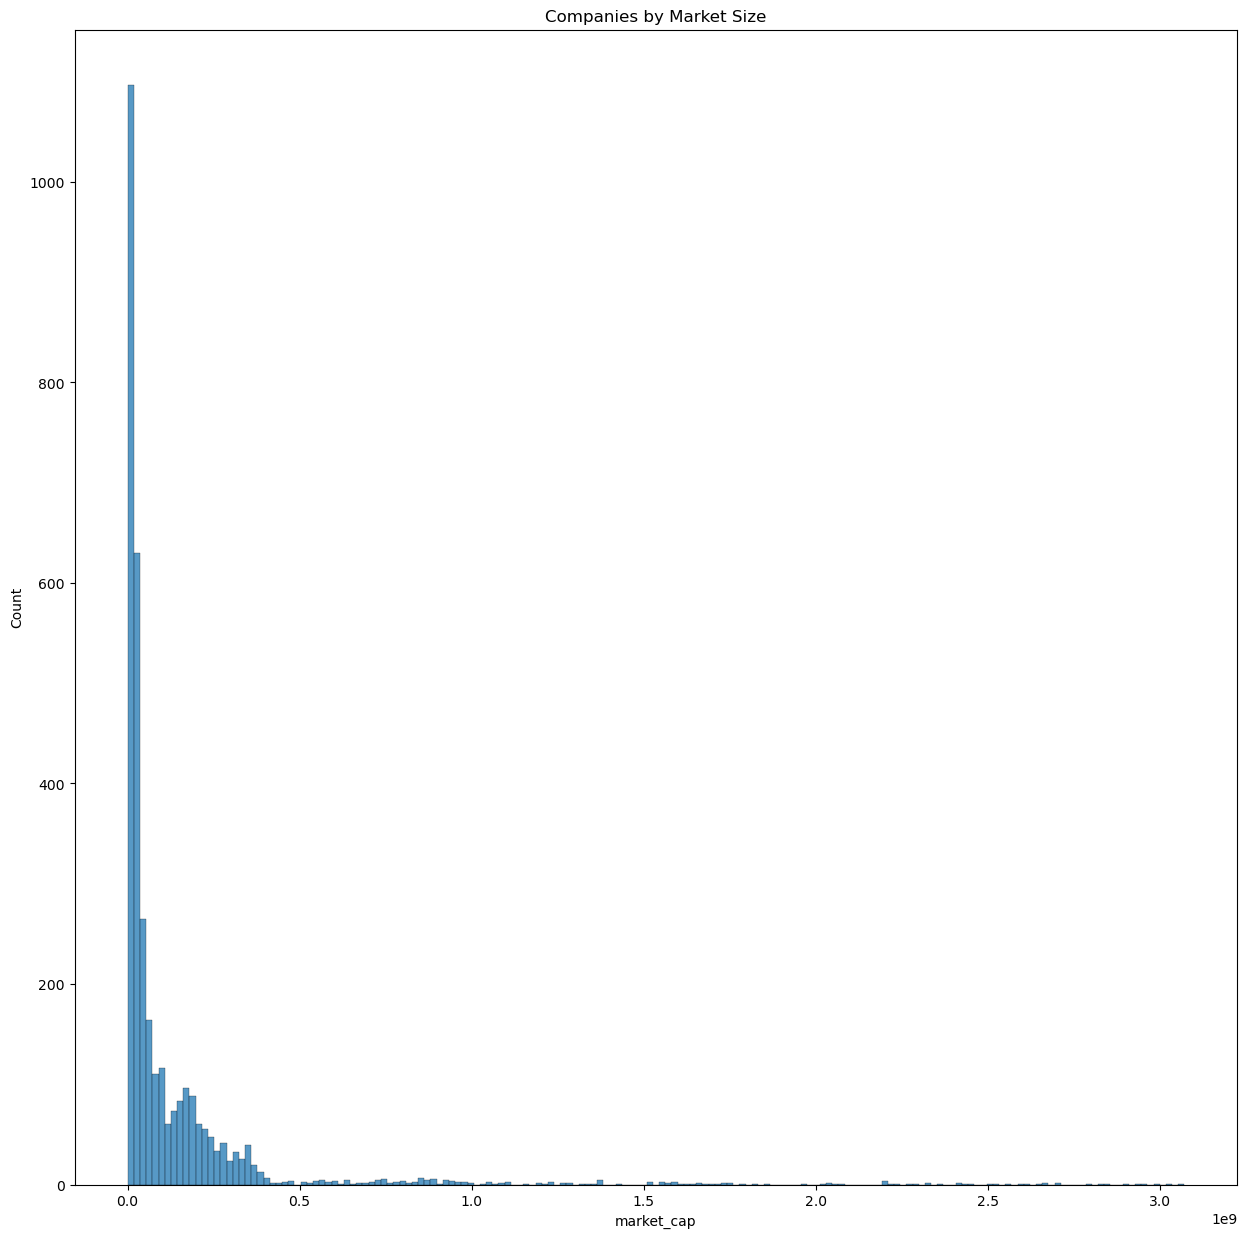

In [230]:
# Set the global size of the figure
fig, ax = plt.subplots()

# Calculate the maximum market capitalization
max_size = merged_data['market_cap'].max()

# Plot the histogram
ax = sns.histplot(data=merged_data, x="market_cap", binrange=(0, max_size))
ax.set_title('Companies by Market Size')  # Set the title

# Define the image size
fig.set_figheight(15)
fig.set_figwidth(15)

# Show the figure
plt.show()

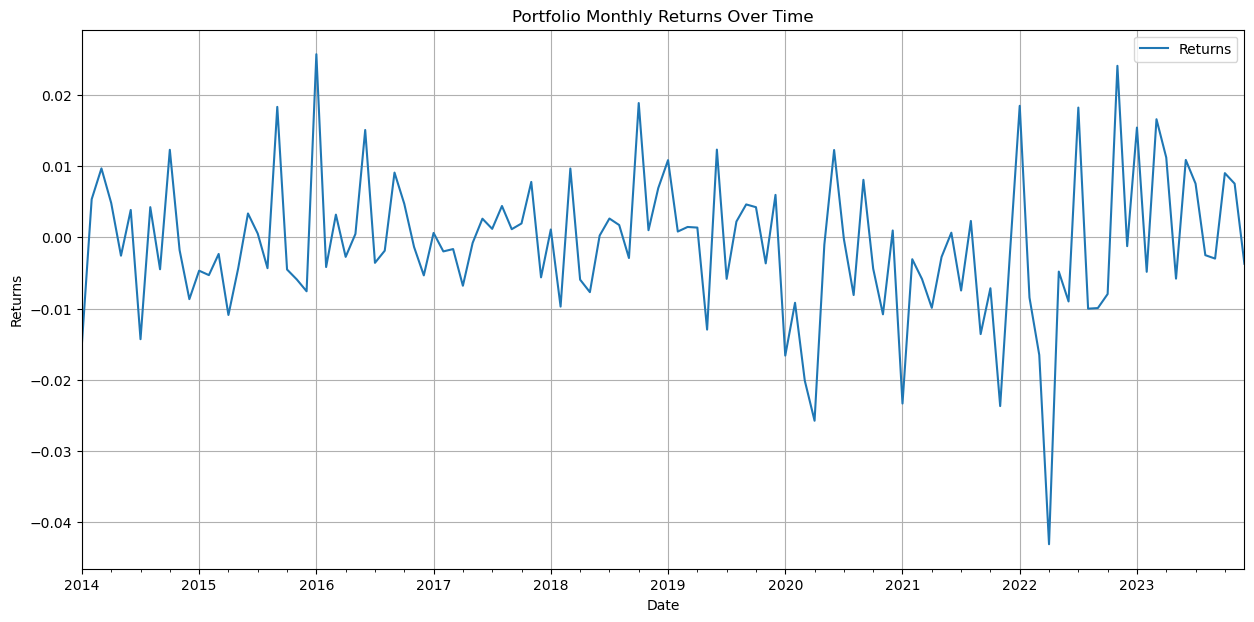

In [231]:
# Assuming final_data is defined
ret_data = merged_data[["RET", "TICKER", "date"]].copy()  # Create a copy to work on to avoid affecting original data

# Create equal weights safely using loc
ret_data['eq_weights'] = 1 / ret_data.groupby('date')['TICKER'].transform('size')

# Calculate monthly return of the equally weighted portfolio containing all stocks
# Use loc to ensure the operation is directly on the DataFrame
ret_data.loc[:, 'return_stock_ew'] = ret_data['RET'].astype(float) * ret_data['eq_weights']

# Calculate the total returns for each date
ret_data.loc[:, 'Returns'] = ret_data.groupby('date')['return_stock_ew'].transform('sum')

# Drop duplicates and set index
unique_ret_data = ret_data[['date', 'Returns']].drop_duplicates().set_index('date')

# Plot the portfolio returns over time
unique_ret_data.plot(grid=True, figsize=(15, 7))
plt.title('Portfolio Monthly Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.grid(True)

# Save the graph
plt.show()

# 5. Feature Engineering and Preprocessing.

Our feature engineering is relatively simple the associated comments describe how we proceeded.

In [232]:
def mm(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

mm("""graph TD
    A[Import Data] --> B[Stock Data]
   subgraph "Feature Engineering"
        B --> F[Calculate Momentum, Volatility, etc.]
    end
    A --> C[Financial Report Data]
    A --> D[Macroeconomic Indicators]
    F --> H[Resample to Monthly]
    H & C & D --> G[Merge Datasets]
   
   subgraph "Preprocessing Pipeline"
        G --> J[Handle NaN & Set Index]
        J --> K[Handle Missing Values]
        K --> L[Normalization]
        L --> M[Feature Lagging]
    end
   
    M --> N[Merge with Return Ratio]
   
   subgraph "Preprocessing Pipeline"
        N --> O[Feature Selection Pipeline]
        O --> P[Select K Best 20 Variables]
    end
    P --> Q[Model Training Preparation Complete]
   """)

In [233]:
merged_data.columns

Index(['date', 'TICKER', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil',
       'pe_exi', 'pe_inc', 'ps',
       ...
       'Rel_to_high', 'SUV', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'BM', 'ME', 'Size',
       'Momentum', 'ShortTermReversal'],
      dtype='object', length=142)

In [330]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, QuantileTransformer, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FunctionTransformer, Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import re




class ColumnTrackerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, func):
        self.func = func
        self.columns = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed, self.columns = self.func(X)
        print("Columns tracked by ColumnTrackerTransformer:", self.columns)
        return pd.DataFrame(X_transformed, columns=self.columns)

    def get_feature_names_out(self, input_features=None):
        return self.columns
    
    # use below to debug

    # def __init__(self, func, name=''):
    #     self.func = func
    #     self.name = name
    #     self.input_columns = None
    #     self.output_columns = None

    # def fit(self, X, y=None):
    #     return self

    # def transform(self, X):
    #     self.input_columns = list(X.columns) if isinstance(X, pd.DataFrame) else None
    #     X_transformed = self.func(X)
    #     if isinstance(X_transformed, tuple):
    #         X_transformed, self.output_columns = X_transformed
    #     else:
    #         self.output_columns = list(X_transformed.columns) if isinstance(X_transformed, pd.DataFrame) else None
        
    #     print(f"{self.name} input columns: {self.input_columns}")
    #     print(f"{self.name} output columns: {self.output_columns}")
        
    #     return X_transformed

    # def get_feature_names_out(self, input_features=None):
    #     return self.output_columns
    
class DebugTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, step_name):
        self.step_name = step_name

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        print(f"\nAfter {self.step_name}:")
        print(f"Type: {type(X)}")
        print(f"Shape: {X.shape if hasattr(X, 'shape') else 'N/A'}")
        
        if isinstance(X, pd.DataFrame):
            print(f"Columns: {X.columns.tolist()}")
            print(f"Index: {X.index.names}")
            print(f"Sample data:\n{X.head()}")
        elif isinstance(X, np.ndarray):
            print("NumPy array - first few rows:")
            print(X[:5])
        else:
            print(f"Unrecognized type: {type(X)}")
            print("Unable to display sample data")

        print("\n" + "="*50 + "\n")
        
        missing_values = X.isnull().sum()
        print(missing_values[missing_values > 0])

        return X

class NaNHandler(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_exclude=['date', 'TICKER']):
        self.columns_to_exclude = columns_to_exclude

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # 处理所有列，包括 RET
        columns_to_process = [col for col in X.columns if col not in self.columns_to_exclude]
        
        # 对于数值列，用中位数填充
        numeric_columns = X[columns_to_process].select_dtypes(include=[np.number]).columns
        X[numeric_columns] = X[numeric_columns].fillna(X[numeric_columns].median())
        
        # 对于非数值列，用众数填充
        non_numeric_columns = [col for col in columns_to_process if col not in numeric_columns]
        for col in non_numeric_columns:
            X[col] = X[col].fillna(X[col].mode().iloc[0] if not X[col].mode().empty else 'Unknown')
        
        return X
    
class SetIndexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, index_columns=['date', 'TICKER']):
        self.index_columns = index_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.set_index(self.index_columns)
    
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.group_vars = {
            'historical': ['Momentum', 'r12_2', 'r12_7', 'r36_13', 'ShortTermReversal', 'LME', 'LTurnover', 'r2_1', 'RET_lag_1_mon'],
            'trading': ['DollarVolume', 'spread'],
            'long_term': ['Momentum', 'r12_2', 'r12_7', 'r36_13'],
            'short_term': ['ShortTermReversal', 'LME', 'LTurnover', 'r2_1'],
            'beta': ['Beta', 'BetaSquared', 'idio_vol']
        }

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, tuple):
            df, _ = X
        else:
            df = X
        df = df.copy()
        df = df.replace([np.inf, -np.inf], np.nan)
        print("Initial shape of df:", df.shape)
        print("Initial columns in df:", df.columns)
        
        processing_steps = [
            ('_handle_group_vars', self._handle_group_vars),
            ('_handle_special_cases', self._handle_special_cases),
            ('_handle_voltality', self._handle_voltality),
            ('_handle_52_week_high', self._handle_52_week_high),
            ('_handle_remaining', self._handle_remaining)
        ]
        
        for step_name, step_func in processing_steps:
            try:
                df = step_func(df)
                if df is None:
                    print(f"Error: DataFrame became None after {step_name}")
                    return X  # Return original DataFrame if any step fails
                print(f"Shape after {step_name}:", df.shape)
            except Exception as e:
                print(f"Error in {step_name}: {str(e)}")
                return X  # Return original DataFrame if any step fails
        
        print("Final shape of df:", df.shape)
        return df
    
    def _handle_group_vars(self, df):
        for group, vars in self.group_vars.items():
            if group in ['historical', 'short_term']:
                # 使用 transform 而不是 apply
                df[vars] = df.groupby(level='TICKER')[vars].transform(lambda x: x.ffill().bfill())
            
            df[vars] = df[vars].fillna(df[vars].median())
            
            if group in ['long_term', 'short_term', 'beta']:
                for var in vars:
                    df[var] = df.groupby('SICCD')[var].transform(lambda x: x.fillna(x.median()))
                    df[var] = df[var].fillna(df[var].median())
        
        return df

    def _handle_special_cases(self, df):
        if df is None:
            print("Error: df is None in _handle_special_cases")
            return None
    
        print("Shape of df in _handle_special_cases:", df.shape)
        print("Columns in df:", df.columns)
        
        try:
            # Check if required columns exist
            required_columns = ['SUV', 'Momentum', 'SICCD']
            for col in required_columns:
                if col not in df.columns:
                    print(f"Error: Column '{col}' not found in DataFrame")
                    return None
            
            # Handle SUV
            df['SUV'] = df['SUV'].fillna(0)
            
            # Handle Momentum
            if df['SICCD'].nunique() > 0:
                df['Momentum'] = df.groupby('SICCD')['Momentum'].transform(lambda x: x.fillna(x.mean()))
            else:
                print("Warning: 'SICCD' column is empty or all values are NaN")
            df['Momentum'] = df['Momentum'].fillna(df['Momentum'].median())
            
            print("Shape of df at the end of _handle_special_cases:", df.shape)
            return df
        except Exception as e:
            print(f"Error in _handle_special_cases: {str(e)}")
            return None

    def _handle_voltality(self, df):
        if df is None or df.empty:
            print("Error: DataFrame is None or empty in _handle_beta")
            return df

        try:
            # 对Beta相关指标使用行业平均值填充
            beta_indicators = ['Beta', 'BetaSquared','idio_vol']
            for indicator in beta_indicators:
                df[indicator] = df.groupby('SICCD')[indicator].transform(lambda x: x.fillna(x.median()))
            
            # 如果仍有缺失值（例如，某些公司可能全部为NaN），使用整体中位数填充
            for indicator in beta_indicators:
                df[indicator] = df[indicator].fillna(df[indicator].median())
            
            print(f"Beta calculation completed. New DataFrame shape: {df.shape}")
            return df
        except Exception as e:
            print(f"Error in Beta calculation: {str(e)}")
            return None

    def _handle_52_week_high(self, df):
        if df is None:
            print("Error: df is None in _handle_52_week_high")
            return None

        print("Shape of df in _handle_52_week_high:", df.shape)
        print("Columns in df:", df.columns)

        # 创建临时DataFrame来存储中间结果
        df_temp = pd.DataFrame(index=df.index)

        # 计算3个月和1个月高点
        df_temp['3_month_high'] = df.groupby(level='TICKER')['PRC'].transform(lambda x: x.rolling(window=63).max())
        df_temp['Rel_to_3month_high'] = df['PRC'] / df_temp['3_month_high']

        df_temp['1_month_high'] = df.groupby(level='TICKER')['PRC'].transform(lambda x: x.rolling(window=21).max())
        df_temp['Rel_to_1month_high'] = df['PRC'] / df_temp['1_month_high']

        # 处理52周高点和相对高点的缺失值
        for col in ['52_week_high', 'Rel_to_high']:
            df[col] = df.groupby(level='TICKER')[col].transform(lambda x: x.ffill(limit=3))

        # 使用3个月高点填充
        df['52_week_high'] = df['52_week_high'].fillna(df_temp['3_month_high'])
        df['Rel_to_high'] = df['Rel_to_high'].fillna(df_temp['Rel_to_3month_high'])

        # 使用1个月高点填充
        df['52_week_high'] = df['52_week_high'].fillna(df_temp['1_month_high'])
        df['Rel_to_high'] = df['Rel_to_high'].fillna(df_temp['Rel_to_1month_high'])

        # 使用当前价格和1填充剩余缺失值
        df['52_week_high'] = df['52_week_high'].fillna(df['PRC'])
        df['Rel_to_high'] = df['Rel_to_high'].fillna(1)

        return df

    def _handle_remaining(self, df):
        if df is None:
            print("Error: df is None in _handle_remaining")
            return None
        
        print("Shape of df at the start of _handle_remaining:", df.shape)
        print("Columns in df:", df.columns)

        try:
            numeric_cols = df.select_dtypes(include=[np.number]).columns
            categorical_cols = df.select_dtypes(exclude=[np.number]).columns

            for col in numeric_cols:
                if df[col].isna().any():
                    df[col] = df.groupby('SICCD')[col].transform(lambda x: x.fillna(x.median()))
                    df[col] = df[col].fillna(df[col].median())

            for col in categorical_cols:
                if df[col].isna().any():
                    df[col] = df.groupby('SICCD')[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Unknown'))
                    df[col] = df[col].fillna(df[col].mode().iloc[0] if not df[col].mode().empty else 'Unknown')

            print("Shape of df at the end of _handle_remaining:", df.shape)
            return df
        except Exception as e:
            print(f"Error in _handle_remaining: {str(e)}")
            return df  # Return the original df even if there's an error

class LaggerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, monthly_features):
        self.monthly_features = monthly_features

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lagged_features = {}
        for var in X.columns:
            if var in self.monthly_features:
                lagged_features[var] = X[var].groupby(X.index.get_level_values('TICKER')).shift(1)
            else:
                lagged_features[var] = X[var].groupby(X.index.get_level_values('TICKER')).shift(6)
        
        result = pd.DataFrame(lagged_features, index=X.index)
        result = result.dropna()
        return result
    
    # another version: keep the lag data and orignal data

    # def transform(self, X):
    #     lagged_features = {}
    #     for var in X.columns:
    #         if var in self.monthly_features:
    #             lagged_features[f'{var}_lag'] = X[var].groupby(X.index.get_level_values('TICKER')).shift(1)
    #         else:
    #             lagged_features[f'{var}_lag'] = X[var].groupby(X.index.get_level_values('TICKER')).shift(6)
        
    #     result = pd.concat([X, pd.DataFrame(lagged_features, index=X.index)], axis=1)

    #     result = result.dropna()
    #     return result
    
    
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, variables_to_keep):
        self.variables_to_keep = variables_to_keep

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            # 选择指定的变量
            columns_to_keep = [col for col in X.columns if col in self.variables_to_keep]
            return X[columns_to_keep]
        else:
            raise ValueError("Input X must be a pandas DataFrame")
        
    
def create_preprocessing_pipeline(merged_data):
    # Define feature groups
    minmax_cols = ['CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'dpr', 'npm', 
                   'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax']
    log_standard_cols = ['ps', 'pcf', 'debt_ebitda', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio']
    yeojohnson_cols = ['aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf']
    ratio_cols = ['equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio']
    turn_cols = ['inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'cash_conversion']
    quantile_cols = ['intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'sale_invcap', 'sale_equity', 'sale_nwc']
    robust_cols = ['int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'short_debt', 'curr_debt', 'lt_debt', 
                   'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield',
                   'r2_1', 'r12_2', 'r12_7', 'Volatility', 'SUV', '52_week_high', 'Rel_to_high']
    min_max_features = ['vwretd', 'ewretd', 'sprtrn', 'Beta', 'BetaSquared', 'idio_vol', 'spread', 'BM', 'ME', 'Size',
                        'Momentum', 'ShortTermReversal', 'LME', 'LTurnover']
    z_score_features = ['PRC', 'VOL', 'SHROUT', 'BIDLO', 'ASKHI', 'OPENPRC', 'market_cap', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'DollarVolume']

    # Identify categorical features
    categorical_features = ['COMNAM', 'SHRCD', 'EXCHCD', 'SICCD']

    # Define non-annual features for lagging
    monthly_features = [
        'Size', 'Momentum', 'r2_1', 'r12_2', 'r12_7',
        'ShortTermReversal', 'DollarVolume', 'spread', 'idio_vol',
        'Beta', 'BetaSquared', 'Volatility', 'SUV',
        '52_week_high', 'Rel_to_high', 'TB3MS', 'T10Y2Y', 'BAA10Y',
        'vwretd', 'ewretd', 'sprtrn', 'LME', 'LTurnover'
    ]

    # Define features to keep
    variables_to_keep = [
        'TICKER',
        'Size', 'bm', 'Momentum', 'r2_1', 'r12_2', 'r12_7', 
        'ShortTermReversal', 'market_cap', 'DollarVolume', 'spread',
        'RET', 'idio_vol', 'Beta', 'BetaSquared', 
        'pe_op_basic', 'pe_op_dil',
        'Volatility', 'SUV',
        '52_week_high', 'Rel_to_high',
        'TB3MS', 'T10Y2Y', 'BAA10Y', 
        'roa', 'roe', 'roce', 'debt_assets', 'debt_capital', 'de_ratio',
        'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'inv_turn',
        'accrual',
        'vwretd', 'ewretd', 'sprtrn',
        'LME', 'LTurnover'
    ]
    
    # # Check which variables are actually present in the data
    # available_vars = [var for var in variables_to_keep if var in merged_data.columns]
    # print(f"Available variables: {available_vars}")
    # print(f"Missing variables: {set(variables_to_keep) - set(available_vars)}")

    class DataFrameColumnTransformer(ColumnTransformer):
        def __init__(self, transformers, remainder='drop', sparse_threshold=0.3,
                    n_jobs=None, transformer_weights=None, verbose=False,
                    verbose_feature_names_out=True):
            super().__init__(
                transformers=transformers, remainder=remainder,
                sparse_threshold=sparse_threshold, n_jobs=n_jobs,
                transformer_weights=transformer_weights, verbose=verbose,
                verbose_feature_names_out=verbose_feature_names_out

            )

        def fit_transform(self, X, y=None):
            result = super().fit_transform(X)
            self.feature_names_out_ = self.get_feature_names_out()
            return pd.DataFrame(result, columns=self.feature_names_out_, index=X.index)

        def transform(self, X):
            result = super().transform(X)
            return pd.DataFrame(result, columns=self.feature_names_out_, index=X.index)
        
        # def _remove_prefix(self, feature_names):
        #     print(f"_remove_prefix called with {len(feature_names)} feature names")  # Debug print
        #     print(f"First few feature names: {feature_names[:5]}")  # Debug print
        
        #     # Get all transformer names
        #     transformer_names = [name for name, _, _ in self.transformers]
        #     print("transformer_names",transformer_names)
        #     # Function to remove prefix for a single feature name
        #     def remove_single_prefix(name):
        #         for prefix in transformer_names:
        #             if name.startswith(f"{prefix}__"):
        #                 print("detect prefix with 2 letter long")
        #                 return name[len(prefix)+2:]
        #             elif name.startswith(f"{prefix}_"):
        #                 print("detect prefix with 1 letter long")
        #                 return name[len(prefix)+1:]
        #             print("no prefix detected")
        #         return name  # If no prefix matches, return the original name

        #     # Apply the function to all feature names
        #     return [remove_single_prefix(name) for name in feature_names]
    
    class LogTransformer(BaseEstimator, TransformerMixin):
        def __init__(self, log_standard_cols, log_offset=1e-8):
            self.log_standard_cols = log_standard_cols
            self.log_offset = log_offset
            self.scalers = {}


        def fit(self, X, y=None):
            for col in self.log_standard_cols:
                self.scalers[col] = StandardScaler()
                self.scalers[col].fit(np.log1p(X[col].clip(lower=self.log_offset)).values.reshape(-1, 1))
            return self

        def transform(self, X):
            X_transformed = pd.DataFrame(index=X.index)

            for col in self.log_standard_cols:
                X_transformed[col] = self.scalers[col].transform(
                    np.log1p(X[col].clip(lower=self.log_offset)).values.reshape(-1, 1)
                )

            return X_transformed

        def get_feature_names_out(self, input_features=None):
            if input_features is None:
                raise ValueError("input_features should be provided.")
            return np.array([f"{feature}" for feature in input_features])
    
    class FeatureNameCleaner(BaseEstimator, TransformerMixin):
        def __init__(self, prefix_pattern=r'^[^_]+__'):
            self.prefix_pattern = prefix_pattern

        def fit(self, X, y=None):
            return self

        def transform(self, X):
            if not isinstance(X, pd.DataFrame):
                return X
            X.columns = [re.sub(self.prefix_pattern, '', col) for col in X.columns]
            return X

        def get_feature_names_out(self, input_features=None):
            if input_features is None:
                raise ValueError("input_features should be provided.")
            return np.array([re.sub(self.prefix_pattern, '', feature) for feature in input_features])
    
    # 创建 calculate_variables_step
    # calculate_variables_step = ColumnTrackerTransformer(calculate_variables)
    
    # Create the preprocessor
    preprocessor = DataFrameColumnTransformer(
        transformers=[
            ('minmax', MinMaxScaler(), minmax_cols),
            ('log_standard', Pipeline([
                ('log', LogTransformer(log_standard_cols)),
                ('scaler', StandardScaler())
            ]), log_standard_cols),
            ('yeojohnson', PowerTransformer(method='yeo-johnson'), yeojohnson_cols),
            ('ratio', MinMaxScaler(feature_range=(0.001, 0.999)), ratio_cols),
            ('turn', PowerTransformer(method='yeo-johnson'), turn_cols),
            ('quantile', QuantileTransformer(output_distribution='normal'), quantile_cols),
            ('robust', RobustScaler(), robust_cols),
            ('minmax_features', MinMaxScaler(), min_max_features),
            ('z_score', StandardScaler(), z_score_features),
            # ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False  # 添加这个参数
    )
    
    # 创建一个函数来获取最新的列名
    def get_latest_columns(pipeline, X):
        for name, transform in pipeline.steps:
            if name == 'calculate_variables':
                X = transform.transform(X)
                return transform.columns
        return X.columns
    
    # def calculate_variables(df):
    #     # Benchmark features
    #     df['BM'] = df['bm']
    #     df['ME'] = df['market_cap']
    #     df['Size'] = np.log(df['ME'])
        
    #     # Momentum (11-month return, 1 month ago)
    #     df['Momentum'] = df.groupby('TICKER')['RET'].transform(
    #         lambda x: x.rolling(window=11).apply(lambda x: (1 + x).prod() - 1).shift(1)
    #     )
        
    #     # Short-term reversal
    #     df['ShortTermReversal'] = df.groupby('TICKER')['RET'].shift(1)
        
    #     # Other calculations (add more as needed)
    #     df['Volatility'] = df.groupby('TICKER')['RET'].transform(
    #         lambda x: x.rolling(window=20, min_periods=1).std()
    #     )
    #     new_columns = list(df.columns)
    #     return df, new_columns

    # Create the full pipeline
    full_pipeline = Pipeline([
        ('nan_handler', NaNHandler()),
        ('debug_nan', DebugTransformer('nan_handler')),

        ('set_index', SetIndexTransformer()),
        ('debug_0', DebugTransformer('set_index')),

        # ('calculate_variables', ColumnTrackerTransformer(calculate_variables)),
        # ('debug_1', DebugTransformer('calculate_variables')),

        ('missing_value_handler', MissingValueHandler()),
        ('debug_2', DebugTransformer('missing_value_handler')),

        # ('preprocessor', preprocessor),
        # # ('feature_name_cleaner', FeatureNameCleaner()), 
        # ('debug_3', DebugTransformer('preprocessor')),

        ('lagger', LaggerTransformer(monthly_features)),
        ('debug_5', DebugTransformer('feature_lagger')),

        ('feature_selector', FeatureSelector(variables_to_keep)),
        ('debug_4', DebugTransformer('feature_selector')),

    ])
    
    latest_columns = get_latest_columns(full_pipeline, merged_data)
    available_vars = [var for var in variables_to_keep if var in latest_columns]
    full_pipeline.named_steps['feature_selector'].variables_to_keep = available_vars

    return full_pipeline

# Apply the pipeline to your data
X_df = merged_data  # 不需要提前移除 RET 列

preprocessing_pipeline = create_preprocessing_pipeline(X_df)
X_preprocessed = preprocessing_pipeline.fit_transform(X_df)

# 获取当前的 RET 作为目标变量
y_preprocessed = merged_data.set_index(['date', 'TICKER'])['RET']

# 确保 X 和 y 的索引对齐
common_index = X_preprocessed.index.intersection(y_preprocessed.index)
X_preprocessed = X_preprocessed.loc[common_index]
y_preprocessed = y_preprocessed.loc[common_index]

print(X_preprocessed.head())
# print(X_preprocessed.shape())
print(y_preprocessed.head())
# print(y_preprocessed.shape())




After nan_handler:
Type: <class 'pandas.core.frame.DataFrame'>
Shape: (3382, 142)
Columns: ['date', 'TICKER', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc', 'ps', 'pcf', 'dpr', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe', 'roce', 'efftax', 'aftret_eq', 'aftret_invcapx', 'aftret_equity', 'pretret_noa', 'pretret_earnat', 'GProf', 'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio', 'int_debt', 'int_totdebt', 'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda', 'short_debt', 'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf', 'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio', 'intcov', 'intcov_ratio', 'cash_ratio', 'quick_ratio', 'curr_ratio', 'cash_conversion', 'inv_turn', 'at_turn', 'rect_turn', 'pay_turn', 'sale_invcap', 'sale_equity', 'sale_nwc', 'rd_sale', 'adv_sale', 'staff_sale', 'accrual', 'ptb', 'PEG_trailing', 'divyield', 'cash_conversion_imputed', 'sale_nwc_imputed', 'divyield_impu

In [331]:
X_preprocessed.to_csv('preprocessed_pipeline_outcome.csv')

In [332]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline

class FeatureNameTracker(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names = None

    def fit(self, X, y=None):
        self.feature_names = X.columns.tolist()
        return self

    def transform(self, X):
        return X

    def get_feature_names(self):
        return self.feature_names
    
def create_feature_selection_pipeline(X, k=10):
    # 创建预处理pipeline
    # preprocessing_pipeline = create_preprocessing_pipeline(X)
    
    # 创建包含预处理和特征选择的完整pipeline
    full_pipeline = Pipeline([
        # ('preprocessing', preprocessing_pipeline),
        ('feature_name_tracker', FeatureNameTracker()),
        ('feature_selection', SelectKBest(score_func=f_regression, k=k))
    ])
    
    return full_pipeline

# 设置要选择的特征数量
k = 20  # 您可以根据需要调整这个值

# 创建新的pipeline
feature_selection_pipeline = create_feature_selection_pipeline(X_preprocessed, k=k)

# 使用新pipeline处理数据
X_selected = feature_selection_pipeline.fit_transform(X_preprocessed, y_preprocessed)

# 获取预处理后的特征名称
preprocessed_feature_names = feature_selection_pipeline.named_steps['feature_name_tracker'].get_feature_names()

# 获取选中的特征索引
selected_indices = feature_selection_pipeline.named_steps['feature_selection'].get_support()

# 获取选中的特征名称
selected_feature_names = [preprocessed_feature_names[i] for i in range(len(preprocessed_feature_names)) if selected_indices[i]]

print(f"选中的特征: {selected_feature_names}")

选中的特征: ['bm', 'pe_op_basic', 'pe_op_dil', 'roe', 'curr_ratio', 'accrual', 'RET', 'sprtrn', 'LTurnover', 'DollarVolume', 'Volatility', 'BetaSquared', 'r2_1', 'r12_7', 'SUV', 'TB3MS', 'T10Y2Y', 'BAA10Y', 'Momentum', 'ShortTermReversal']


In [236]:
# # Define features excluding 'TICKER', 'RET', 'RET_interp', 'RET_calc'
# features = merged_data.columns[~merged_data.columns.isin(['TICKER', 'RET', 'RET_interp', 'RET_calc','date'])].tolist()
# X = merged_data[features]
# y = merged_data['RET']

# # Drop rows where the target variable y is NaN
# X = X[~y.isna()]
# y = y.dropna()

# # Identify categorical and numerical features
# categorical_features = X.select_dtypes(include=['object']).columns.tolist()
# numerical_features = [col for col in X.columns if col not in categorical_features]

# # Define the preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='mean')),
#             ('scaler', StandardScaler())
#         ]), numerical_features),
#         ('cat', Pipeline(steps=[
#             ('imputer', SimpleImputer(strategy='most_frequent')),
#             ('onehot', OneHotEncoder(handle_unknown='ignore'))
#         ]), categorical_features)
#     ])

# # Apply the preprocessing steps
# X_preprocessed = preprocessor.fit_transform(X)

# # Get feature names after preprocessing
# num_features = preprocessor.named_transformers_['num'].named_steps['scaler'].get_feature_names_out(numerical_features)
# cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# feature_names = list(num_features) + list(cat_features)

# # Convert the preprocessed data back to a DataFrame
# X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=feature_names, index=X.index)

# X_preprocessed_df

# # Split the data into training and testing sets and keep track of indices
# X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_preprocessed_df, y, X_preprocessed_df.index, test_size=0.2, random_state=42, shuffle=False)

# print("Preprocessed feature names:\n", feature_names)

# 6. Predictive and Prescriptive Analysis

Our work is largely inspired by the work of Gu et al 2020 and Michael Pinelis and David Ruppert 2021. They describe the Gradient boosted Trees and Random Forests as the best performing models for Empirical Asset Pricing.

We proceed by first creating a Random Forest model and using its inference here to generate a list of feature importances, eventually fed into XGBoost.

In [333]:
from sklearn.metrics import mean_absolute_percentage_error

# 分割数据集为训练集和最后一个月的预测集
last_month = X_preprocessed.index.get_level_values(1).max()
X = X_preprocessed[X_preprocessed.index.get_level_values(1) < last_month]
y = y_preprocessed[y_preprocessed.index.get_level_values(1) < last_month]

X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, X.index, test_size=0.1, random_state=42, shuffle=False)

X_predict = X_preprocessed[X_preprocessed.index.get_level_values(1) == last_month]
y_actual = y_preprocessed[y_preprocessed.index.get_level_values(1) == last_month]

features = selected_feature_names

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)
# 训练模型

# 模型参数
rf_params = {
    'n_estimators': 100,
    # 'max_depth': 21,
    # 'min_samples_split': 2,
    # 'min_samples_leaf': 4,
    # 'max_features': 'auto',
    'random_state': 42,
    # 'warmstart': True
}

# 2. 模型创建和训练
rf_model = RandomForestRegressor(**rf_params)
rf_model.fit(X_train, y_train)

# 3. 模型评估
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mape}")

print(f"R-squared Score: {r2}")

# 在最后一个月的预测集上进行预测
y_predict = rf_model.predict(X_predict)

r2_predict = r2_score(y_actual, y_predict)
mse_predict = mean_squared_error(y_actual, y_predict)
mape_predict = mean_absolute_percentage_error(y_actual, y_predict)

print(f'Prediction R²: {r2_predict:.4f}')
print(f'Prediction MSE: {mse_predict:.4f}')
print(f'Prediction MAPE: {mape_predict:.4f}')

(2739, 40) (2739,) (305, 40) (305,)
Mean Squared Error: 0.0004608160200915286
Mean Absolute Error: 189049299637.87793
R-squared Score: 0.15907459492121168
Prediction R²: 0.2154
Prediction MSE: 0.0003
Prediction MAPE: 2.3809


In [238]:
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X_preprocessed_df, y, X_preprocessed_df.index, test_size=0.1, random_state=42, shuffle=False)

# # Train the Random Forest model
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Feature importances
# importances = rf_model.feature_importances_
# indices = np.argsort(importances)[::-1]

# # Extract the top 20 features
# top_20_indices = indices[:20]
# top_20_features = X_train.columns[top_20_indices]

# # Print the top 20 feature ranking
# print("Top 20 Feature ranking:")
# for i, feature in enumerate(top_20_features):
#     print(f"{i + 1}. feature {feature} ({importances[top_20_indices[i]]})")

# X_top_20 = X_preprocessed[top_20_features]

# # Split the data into training and testing sets using the top 20 features
# X_train_top_20, X_test_top_20, y_train, y_test, train_indices_top_20, test_indices_top_20 = train_test_split(X_top_20, y, X_top_20.index, test_size=0.1, random_state=42, shuffle=False)

For our portfolio optimization we use cvxpy and mean variance optimization assuming risk neutrality. It must be said that the portfolio gains different values based on our personal risk preference.

In [334]:
def convert_to_numeric(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

X_train = convert_to_numeric(X_train)
X_test = convert_to_numeric(X_test)
X_predict = convert_to_numeric(X_predict)

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)


# 3. 模型评估
y_pred = xgb_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mape}")

print(f"R-squared Score: {r2}")

# 在最后一个月的预测集上进行预测
y_predict = xgb_model.predict(X_predict)

r2_predict = r2_score(y_actual, y_predict)
mse_predict = mean_squared_error(y_actual, y_predict)
mape_predict = mean_absolute_percentage_error(y_actual, y_predict)

print(f'Prediction R²: {r2_predict:.4f}')
print(f'Prediction MSE: {mse_predict:.4f}')
print(f'Prediction MAPE: {mape_predict:.4f}')

/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_2772/2536310572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = pd.to_numeric(df[col], errors='coerce')


Mean Squared Error: 0.000522061931454922
Mean Absolute Error: 310069142016.0805
R-squared Score: 0.04730929038068943
Prediction R²: 0.1538
Prediction MSE: 0.0003
Prediction MAPE: 2.2420


In [240]:
# temporarily commented out to save power

# # Define the parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # Initialize the XGBoost model
# xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# # Perform grid search with cross-validation
# grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# # Get the best model from grid search
# best_model = grid_search.best_estimator_

# # Predict and evaluate
# xgb_pred = best_model.predict(X_test)
# xgb_mse = mean_squared_error(y_test, xgb_pred)
# xgb_r2 = r2_score(y_test, xgb_pred)
# print(f'XGBoost Mean Squared Error: {xgb_mse}')
# print(f'XGBoost R² Score: {xgb_r2}')

In [241]:

# expected_returns = np.array(xgb_pred)
# cov_matrix = np.cov(X_test_top_20)

# # Convex optimization using the predicted weights
# def convex_optimization(expected_returns, cov_matrix, risk_tolerance=0):
#     n = len(expected_returns)
#     weights = cp.Variable(n)
#     portfolio_return = expected_returns @ weights
#     portfolio_risk = cp.norm(cov_matrix @ weights, 1)
#     objective = cp.Maximize(portfolio_return - risk_tolerance * portfolio_risk)
#     constraints = [
#         cp.sum(weights) == 1,
#         weights >= 0,
#         weights <= 0.5
#     ]
#     problem = cp.Problem(objective, constraints)
#     problem.solve()
#     return weights.value, objective.value

# # Print dimensions for debugging
# print(f'Dimensions of expected_returns: {expected_returns.shape}')
# print(f'Dimensions of cov_matrix: {cov_matrix.shape}')

# # Optimize portfolio
# shares, objective_value = convex_optimization(expected_returns, cov_matrix)
# print(f'Optimized Normalized Portfolio Shares: {shares}')
# print(f'Portfolio Return: {objective_value}')

# 7. Assessment

In [347]:
# opt_data = pd.read_csv('model_data.csv')
opt_data = pd.read_csv('preprocessed_pipeline_outcome.csv')

opt_data['date'] = pd.to_datetime(opt_data['date'])
opt_data.set_index(['date', 'TICKER'], inplace=True)
opt_data.sort_index(inplace=True)

opt_features = opt_data.columns[~opt_data.columns.isin(['RET','TICKER'])].tolist()
target = ['RET']

In [325]:
featured_data = pd.read_csv('final_data_after_missing_value_handle_with_better_features.csv')
featured_data['date'] = pd.to_datetime(featured_data['date'])
featured_data.set_index(['date', 'TICKER'], inplace=True)
featured_data.sort_index(inplace=True)


import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action='ignore', category=DataConversionWarning)



In [326]:
import logging

# 创建logger
logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

# 检查处理程序数量
print(f"处理程序数量: {len(logger.handlers)}")

# 移除多余的处理程序
logger.handlers = []

# 只添加一个处理程序
logger.addHandler(logging.StreamHandler())

print("\n清理后:")
logger.info("这是另一条测试日志")
print(f"处理程序数量: {len(logger.handlers)}")

这是另一条测试日志


处理程序数量: 1

清理后:
处理程序数量: 1


In [374]:
pip install --upgrade scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [372]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.base import clone
from sklearn.utils import resample
from sklearn.covariance import LedoitWolf

def convert_to_numeric(df):
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def set_multi_index(df , index_columns=['date', 'TICKER']):
        return df.set_index(index_columns)

def get_data_for_date_range(df, start_date, end_date):
    # return df.loc[start_date:end_date]
    if start_date is None:
        data = df.loc[:end_date]
    else:
        data = df.loc[start_date:end_date]
    if data.empty:
        logger.warning(f"No data found between {start_date} and {end_date}")
    return data

def prepare_training_data(df, features, target):
    X = df[features]
    y = df[target]
    # return X, y
    if X.empty or y.empty:
        logger.warning("Training data is empty.")
    return X, y

def fit_and_predict(model, X_train, y_train, X_test):
    # logger.info(f"fit_and_predict: X_train shape: {X_train.shape}, type: {type(X_train)}")
    # logger.info(f"fit_and_predict: y_train shape: {y_train.shape}, type: {type(y_train)}")
    # logger.info(f"fit_and_predict: X_test shape: {X_test.shape}, type: {type(X_test)}")
    
    # Train the new model
    # logger.info("start fitting")
    model.fit(X_train.values, y_train)
    # logger.info("end fitting")

    predictions = model.predict(X_test.values)    
    # logger.info("end predict")
    # 计算预测方差
    variance = calculate_predicted_variance(model, X_test)
    
    return predictions, variance

def calculate_predicted_variance(model, X_test):
    final_estimator = get_final_estimator(model)
    
    if hasattr(final_estimator, 'predict_proba'):
        proba = final_estimator.predict_proba(X_test)
        logger.info('predict_proba',{np.var(proba)})
        return np.var(proba, axis=1)
    elif hasattr(final_estimator, 'estimators_'):
        predictions = np.array([tree.predict(X_test.values) for tree in final_estimator.estimators_])
        return np.var(predictions, axis=0)
    else:
        logger.warning("模型不提供方差估计，返回固定值")
        return np.full(X_test.shape[0], 1e-6)

def get_final_estimator(model):
    if hasattr(model, 'steps'):  # 检查是否是 Pipeline
        return model.steps[-1][1]  # 返回 Pipeline 的最后一个估计器
    return model

def calculate_predicted_variance(model, X_test):
    final_estimator = get_final_estimator(model)
    
    if hasattr(final_estimator, 'predict_proba'):
        proba = final_estimator.predict_proba(X_test)
        return np.var(proba, axis=1)
    elif hasattr(final_estimator, 'estimators_'):
        predictions = np.array([tree.predict(X_test.values) for tree in final_estimator.estimators_])
        return np.var(predictions, axis=0)
    elif isinstance(final_estimator, xgb.XGBRegressor):
        # XGBoost回归模型处理
        if not isinstance(X_test, xgb.DMatrix):
            dtest = xgb.DMatrix(X_test)
        else:
            dtest = X_test
        
        # 使用预测的叶子索引来估计方差
        leaf_predictions = final_estimator.predict(dtest, pred_leaf=True)
        
        # 获取每个叶子节点的预测值
        predictions = final_estimator.predict(dtest)
        
        # 计算每个样本的方差
        variances = np.zeros(X_test.shape[0])
        for i in range(final_estimator.n_estimators):
            # 对每棵树，计算叶子节点预测值与整体预测值的差异
            tree_preds = predictions if predictions.ndim == 1 else predictions[:, i]
            diff = tree_preds - np.mean(predictions)
            variances += diff ** 2
        
        # 平均方差
        variances /= final_estimator.n_estimators
        
        return variances
    else:
        logger.warning("模型不提供方差估计，返回固定值")
        return np.full(X_test.shape[0], 1e-6)

# 分配相等的权重
def equal_weight_portfolio(expected_returns):
    n = len(expected_returns)
    equal_weights = np.ones(n) / n
    return equal_weights

# 优化投资组合权重
def optimize_portfolio(expected_returns, cov_matrix, lambda_risk_aversion, max_iter=1000):
    n = len(expected_returns)
    
    expected_returns = np.array(expected_returns).flatten()


    def objective(weights):
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(portfolio_return - lambda_risk_aversion * portfolio_volatility)

    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # 权重之和为1
        # {'type': 'ineq', 'fun': lambda x: 0.5 - np.max(x)}  # 单个资产最大权重为50%
    )
    bounds = tuple((0, 1) for _ in range(n))  # 权重在0到1之间

    result = minimize(objective, n * [1./n], method='SLSQP', bounds=bounds, 
                      constraints=constraints, options={'maxiter': max_iter})
    
    if not result.success:
        logger.warning(f"Optimization failed: {result.message}")
        return np.ones(n) / n  # 返回等权重作为后备方案
    
    return result.x



def predict_returns(df, start_date, next_month, features, target, model):
    try:
        logger.info(f"Predicting returns from {start_date} to {next_month}")
        
        # Filter data for the training period (up to and including start_date)
        train = df[df.index.get_level_values('date') <= start_date]
        
        # Filter data for the test period (next_month only)
        test = df[df.index.get_level_values('date') == next_month]

        logger.info(f"Train data shape: {train.shape}")
        logger.info(f"Test data shape: {test.shape}")
        
        X_train, y_train = prepare_training_data(train, features, target)
        X_test = test[features]    
        logger.info(f"X_train shape: {X_train.shape}")
        logger.info(f"y_train shape: {y_train.shape}")
        logger.info(f"X_test shape: {X_test.shape}")
        
        if X_train.empty or y_train.empty:
            raise ValueError("Training data is empty")
        
        if X_test.empty:
            raise ValueError(f"No data available for the next month: {next_month}")
        
        predictions, predicted_variance = fit_and_predict(model, X_train, y_train, X_test)
        logger.info(f"Predictions shape: {predictions.shape}")
        logger.info(f"Predicted variance shape: {predicted_variance.shape}")
                
        # Get actual returns for the test period (next_month)
        actual_returns = test[target]

        # 添加这些日志语句
        logger.info(f"actual_returns shape: {actual_returns.shape}, type: {type(actual_returns)}")
        logger.info(f"predictions shape: {predictions.shape}, type: {type(predictions)}")
        
        # 确保 predictions 和 actual_returns 都是 DataFrame
        predictions_df = pd.DataFrame(predictions, index=actual_returns.index, columns=actual_returns.columns)
        # metrics = calculate_model_metrics(actual_returns, predictions_df)
        # logger.info(f"Model Evaluation Metrics: {metrics}")

        return predictions_df, pd.Series(predicted_variance, index=actual_returns.index), actual_returns
        
    except Exception as e:
        logger.error(f"Error in predict_returns: {str(e)}")
        raise


def calculate_model_metrics(y_true, y_pred):
    """
    计算模型评估指标：MSE, RMSE, MAE, R2
    
    参数:
    y_true (pd.DataFrame): 实际值
    y_pred (pd.DataFrame): 预测值
    
    返回:
    dict: 包含 mse, rmse, mae, r2 的字典
    """
    # 确保输入是DataFrame并且只有一列
    # assert isinstance(y_true, pd.DataFrame) and isinstance(y_pred, pd.DataFrame), "Inputs must be DataFrames"
    # assert y_true.shape[1] == 1 and y_pred.shape[1] == 1, "Inputs must have only one column"
    
    # 计算指标
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return mse, rmse, mae, r2

def get_risk_free_rate(featured_data, date):
    rf_data = featured_data.loc[featured_data.index.get_level_values('date') == date, 'TB3MS']
    if len(rf_data) > 0:
        annual_rf_rate = rf_data.iloc[0] / 100
        logger.info(f"Annual Risk-free rate: {annual_rf_rate}")
        monthly_rf_rate = (1 + annual_rf_rate) ** (1/12) - 1
        logger.info(f"Monthly Risk-free rate: {monthly_rf_rate}")
    else:
        logger.warning(f"No risk-free rate data for {date}. Using average of last 3 months as default.")
        # 使用最近3个月的平均值作为默认值
        last_3_months = featured_data.loc[featured_data.index.get_level_values('date') < date, 'TB3MS'].tail(3)
        if len(last_3_months) > 0:
            annual_rf_rate = last_3_months.mean() / 100
            monthly_rf_rate = (1 + annual_rf_rate) ** (1/12) - 1
        else:
            logger.warning("No historical risk-free rate data available. Using 0 as default.")
            monthly_rf_rate = 0
    return monthly_rf_rate

def estimate_optimal_covariance(historical_data, current_tickers, target_column, min_history_length=252, min_data_pct=0):
    """
    估计最优协方差矩阵，处理不同时间点股票不同的问题，并减少填充的影响。
    
    参数:
    historical_data (pd.DataFrame): 包含历史数据的DataFrame，索引为MultiIndex（日期和股票代码）
    current_tickers (list): 当前时间点的股票代码列表
    target_column (str): 目标列名（例如，'returns'）
    min_history_length (int): 用于估计的最小历史数据长度
    min_data_pct (float): 股票需要的最小数据百分比
    
    返回:
    np.array: 估计的协方差矩阵
    """    
    historical_data = historical_data.sort_index()
    dates = historical_data.index.get_level_values('date').unique()
    recent_dates = dates[-min_history_length:] if len(dates) > min_history_length else dates
    
    recent_data = historical_data.loc[historical_data.index.get_level_values('date').isin(recent_dates)]
    recent_data = recent_data[recent_data.index.get_level_values('TICKER').isin(current_tickers)]
    
    if recent_data.empty:
        raise ValueError("No recent data available for the specified tickers")
    
    pivot_data = recent_data[target_column].unstack(level='TICKER')
    
    # 计算每个股票的数据完整性
    data_completeness = pivot_data.notna().sum() / len(pivot_data)
    valid_tickers = data_completeness[data_completeness >= min_data_pct].index.tolist()

    logger.info(f"estimate: valid tickers: {valid_tickers}")
    
    if not valid_tickers:
        raise ValueError("No stocks with sufficient data")
    
    valid_data = pivot_data[valid_tickers]

    # logger.info(f"estimate: valid_data: {valid_data.head()}")

    
    # 使用线性插值填充缺失值
    filled_data = valid_data.interpolate(method='linear', axis=0).ffill().bfill()
    
    # 计算每个股票的平均收益率和波动率
    mean_returns = filled_data.mean()
    std_returns = filled_data.std()
    
    # 对于缺失值较多的股票，使用其历史平均收益率和波动率来模拟数据
    for ticker in valid_tickers:
        missing_dates = filled_data[ticker].isna()
        if missing_dates.sum() > 0:
            simulated_returns = np.random.normal(mean_returns[ticker], std_returns[ticker], size=missing_dates.sum())
            filled_data.loc[missing_dates, ticker] = simulated_returns
    
    # 计算加权系数
    weights = data_completeness[valid_tickers].values
    weights = weights / weights.sum()
    
    # 加权数据
    weighted_data = filled_data * weights
    
    # 使用Ledoit-Wolf方法估计协方差矩阵
    lw = LedoitWolf()
    # logger.info("start lw fitting")
    cov_matrix = lw.fit(weighted_data.values).covariance_
    # logger.info("end lw fitting")
    
    if isinstance(pivot_data.columns, pd.MultiIndex):
        valid_tickers = [t[1] if isinstance(t, tuple) else t for t in valid_tickers]
        
    return cov_matrix, valid_tickers

def display_portfolio_composition(weights, stocks):
    """
    Display the composition of the portfolio with ticker names and weights.
    
    Parameters:
    weights (numpy.array): Optimized weights for the portfolio
    stocks (pandas.Index or list): The stock tickers in the portfolio
    threshold (float): Minimum weight to include in the display (default: 1%)
    
    Returns:
    pandas.DataFrame: A dataframe showing the portfolio composition
    str: A string representation of the portfolio composition
    """
    # Create a dataframe with tickers and weights
    portfolio = pd.DataFrame({
        'Ticker': stocks,
        'Weight': weights
    })
    threshold=0.01
    # Sort by weight in descending order
    portfolio = portfolio.sort_values('Weight', ascending=False)
    
    # Filter out weights below the threshold
    portfolio = portfolio[portfolio['Weight'] >= threshold]
    
    # Calculate the sum of displayed weights
    displayed_weight_sum = portfolio['Weight'].sum()
    
    # Add a row for "Others" if necessary
    if displayed_weight_sum < 1:
        others_weight = 1 - displayed_weight_sum
        others_row = pd.DataFrame({
            'Ticker': ['Others'],
            'Weight': [others_weight]
        })
        portfolio = pd.concat([portfolio, others_row])
    
    # Format weights as percentages
    portfolio['Weight'] = portfolio['Weight'].apply(lambda x: f"{x:.2%}")
    
    # Reset index for clean display
    portfolio = portfolio.reset_index(drop=True)
    
    # Create a string representation
    portfolio_str = portfolio.to_string(index=False)
    
    return portfolio, portfolio_str


# If you want to save this to a CSV file:
# portfolio_composition.to_csv(f"portfolio_composition_{portfolio_date.date()}.csv", index=False)

In [369]:
# ... [其他辅助函数保持不变] ...

def process_single_period(df, original_data, start_date, next_month, opt_features, target, model, lambda_risk_aversion):
    try:
        logger.info(f"Processing period from {start_date} to {next_month}")
        
        historical_data = convert_to_numeric(df)
        historical_data = historical_data[historical_data.index.get_level_values('date') <= start_date]

        logger.info(f"Historical data shape: {historical_data.shape}")
        
        # predict
        predicted_returns, predicted_variance, actual_returns = predict_returns(df, start_date, next_month, opt_features, target, model)

        logger.info(f"Predicted returns shape: {predicted_returns.shape}")
        logger.info(f"Predicted variance shape: {predicted_variance.shape}")
        logger.info(f"Actual returns shape: {actual_returns.shape}")
        
        if actual_returns.empty:
            raise ValueError("No valid actual returns data after filtering")
        
        # get ticker
        current_tickers = df.loc[next_month].index.get_level_values('TICKER').tolist()
        logger.info(f"Number of stocks for next month: {len(current_tickers)}")

        # get cov based on current ticker's return
        # logger.info(f"process_: current tickers: {current_tickers}")
        cov_matrix, valid_tickers = estimate_optimal_covariance(historical_data, current_tickers, target)
        # logger.info(f"process_: valid tickers: {valid_tickers}")
        # logger.info(f"process_: cov_matrix: {cov_matrix}")


        logger.info(f"Covariance matrix shape: {cov_matrix.shape}")
        logger.info(f"Number of valid tickers: {len(valid_tickers)}")
        
        # 确保 predicted_returns 和 cov_matrix 使用相同的股票
        valid_mask = np.isin(current_tickers, valid_tickers)
        predicted_returns_valid = predicted_returns[valid_mask]
        predicted_variance_valid = predicted_variance[valid_mask]
        
        # 处理 actual_returns_valid 可能是 DataFrame 的情况
        if isinstance(actual_returns, pd.DataFrame):
            logger.info(f"actual_returns is a DataFrame with shape: {actual_returns.shape}")
            actual_returns_valid = actual_returns.loc[actual_returns.index.get_level_values('TICKER').isin(valid_tickers)]
            logger.info(f"actual_returns_valid after filtering: {actual_returns_valid.shape}")
            if actual_returns_valid.empty:
                raise ValueError("No valid actual_returns_valid data after filtering")
            actual_returns_valid = actual_returns_valid.values.flatten()
        else:
            logger.info(f"actual_returns is a numpy array with shape: {actual_returns.shape}")
            actual_returns_valid = actual_returns[valid_mask]
        
        valid_tickers = np.array(current_tickers)[valid_mask]
        # logger.info(f"valid_tickers: {valid_tickers}")

        logger.info(f"Shape of predicted_returns_valid: {predicted_returns_valid.shape}")
        logger.info(f"Shape of actual_returns_valid: {actual_returns_valid.shape}")
        logger.info(f"Number of valid tickers: {len(valid_tickers)}")

        if len(predicted_returns_valid) == 0 or len(actual_returns_valid) == 0:
            logger.warning("No valid data for this period. Skipping...")
            return None

        if cov_matrix.shape[0] != len(predicted_returns_valid):
            raise ValueError(f"Mismatch between covariance matrix shape {cov_matrix.shape} and predicted returns length {len(predicted_returns_valid)}")

        optimal_weights = optimize_portfolio(predicted_returns_valid, cov_matrix, lambda_risk_aversion)
        
        logger.info(f"Shape of optimal_weights: {optimal_weights.shape}")
        # logger.info(f"optimal_weights: {optimal_weights}")

        # 显示投资组合构成
        portfolio_composition, portfolio_str = display_portfolio_composition(optimal_weights, valid_tickers)
        logger.info(f"Portfolio Composition for {next_month}:")
        logger.info(portfolio_str)

        portfolio_return = np.dot(optimal_weights , predicted_returns_valid).item()
        logger.info(f"Calculated portfolio return: {portfolio_return}")

        # portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
        portfolio_volatility = np.sqrt(np.dot(optimal_weights, predicted_variance_valid).item())
        logger.info(f"portfolio_volatility: {portfolio_volatility}")

        rf_rate = get_risk_free_rate(original_data, next_month)
        
        sharpe_ratio = (portfolio_return - rf_rate) / portfolio_volatility #if portfolio_volatility > 0 else np.nan
        logger.info(f"sharpe_ratio: {sharpe_ratio}")

        mse, rmse, mae, r2 = calculate_model_metrics(actual_returns_valid, predicted_returns_valid)
        
        # print(portfolio_composition.to_string(index=False))

        return portfolio_return, sharpe_ratio, mse, rmse, mae, r2

    except Exception as e:
        logger.error(f"Error processing period {start_date} to {next_month}: {str(e)}")
        logger.error(f"Error details: {str(e)}", exc_info=True)
        return None

# 使用示例
target = ['RET']
date = pd.Timestamp('2017-12-31')
next_month = date + pd.offsets.MonthEnd(1)
lambda_risk_aversion = 0.9

result = process_single_period(opt_data, featured_data, date, next_month, opt_features, target, rf_model, lambda_risk_aversion)

if result is not None:
    portfolio_return, sharpe_ratio, mse, rmse, mae, r2 = result
    print(f"Portfolio Return: {portfolio_return:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print("\nPortfolio Composition:")
else:
    print("No valid data for this period.")
    

Processing period from 2017-12-31 00:00:00 to 2018-01-31 00:00:00
Historical data shape: (1124, 40)
Predicting returns from 2017-12-31 00:00:00 to 2018-01-31 00:00:00
Train data shape: (1124, 40)
Test data shape: (27, 40)
X_train shape: (1124, 39)
y_train shape: (1124, 1)
X_test shape: (27, 39)
Predictions shape: (27,)
Predicted variance shape: (27,)
actual_returns shape: (27, 1), type: <class 'pandas.core.frame.DataFrame'>
predictions shape: (27,), type: <class 'numpy.ndarray'>
Predicted returns shape: (27, 1)
Predicted variance shape: (27,)
Actual returns shape: (27, 1)
Number of stocks for next month: 27
estimate: valid tickers: [('RET', 'AAPL'), ('RET', 'AMZN'), ('RET', 'AXP'), ('RET', 'BAC'), ('RET', 'C'), ('RET', 'CBS'), ('RET', 'CHTR'), ('RET', 'COF'), ('RET', 'CVX'), ('RET', 'DVA'), ('RET', 'ITG'), ('RET', 'KO'), ('RET', 'KR'), ('RET', 'LPX'), ('RET', 'LUK'), ('RET', 'MA'), ('RET', 'MCO'), ('RET', 'NVR'), ('RET', 'OXY'), ('RET', 'SIRI'), ('RET', 'TMUS'), ('RET', 'V'), ('RET', '

Portfolio Return: 0.0158
Sharpe Ratio: 0.5849
MSE: 0.0002
RMSE: 0.0136
MAE: 0.0098
R²: 0.2143

Portfolio Composition:


In [373]:
xgb_result = process_single_period(opt_data, featured_data, date, next_month, opt_features, target, xgb_model, lambda_risk_aversion)



Processing period from 2017-12-31 00:00:00 to 2018-01-31 00:00:00
Historical data shape: (1124, 40)
Predicting returns from 2017-12-31 00:00:00 to 2018-01-31 00:00:00
Train data shape: (1124, 40)
Test data shape: (27, 40)
X_train shape: (1124, 39)
y_train shape: (1124, 1)
X_test shape: (27, 39)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/xgboost/data.py:1156: UserWarning: Unknown data type: <class 'xgboost.core.DMatrix'>, trying to convert it to csr_matrix
  warnings.warn(
Error in predict_returns: Not supported type for data.<class 'xgboost.core.DMatrix'>
Error processing period 2017-12-31 00:00:00 to 2018-01-31 00:00:00: Not supported type for data.<class 'xgboost.core.DMatrix'>
Error details: Not supported type for data.<class 'xgboost.core.DMatrix'>
Traceback (most recent call last):
  File "/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_2772/1630255568.py", line 13, in process_single_period
    predicted_returns, predicted_variance, actual_returns = predict_re

In [353]:
def rolling_portfolio_optimization(opt_data, featured_data, start_date, end_date, features, target, model, lambda_risk_aversion, window_size):
    dates = pd.date_range(start_date, end_date, freq='M')
    portfolio_returns = []
    sharpe_ratios = []
    mses = []
    rmses = []
    maes = []
    r2s = []
    result_dates = []

    for i in range(len(dates) - window_size):
        train_start = dates[i]
        train_end = dates[i + window_size - 1]
        next_month = dates[i + window_size]
        
        logger.info(f"Training from {train_start} to {train_end}, predicting for {next_month}")
        
        # 训练模型
        train_data = get_data_for_date_range(opt_data, train_start, train_end)
        X_train, y_train = prepare_training_data(train_data, features, target)
        model.fit(X_train, y_train)
        
        # 处理单个时期并计算投资组合回报率和夏普比率
        portfolio_return, sharpe_ratio, mse, rmse, mae, r2 = process_single_period(opt_data, featured_data, train_end, next_month, features, target, model, lambda_risk_aversion)
        portfolio_returns.append(portfolio_return)
        sharpe_ratios.append(sharpe_ratio)
        mses.append(mse)
        rmses.append(rmse)
        maes.append(mae)
        r2s.append(r2)
        result_dates.append(next_month)

    return pd.DataFrame({
        'date': result_dates,
        'portfolio_return': portfolio_returns,
        'sharpe_ratio': sharpe_ratios,
        'mse': mses,
        'rmse': rmses,
        'mae': maes,
        'r2': r2s
    }).set_index('date')

def calculate_annual_return(monthly_returns):
    """计算年度回报率"""
    annual_return = np.prod(1 + monthly_returns) - 1
    return annual_return

# 使用示例：
start_date = pd.Timestamp('2015-10-31')
end_date = pd.Timestamp('2016-12-31')
# start_date = opt_data.index.get_level_values('date').min()
# end_date = opt_data.index.get_level_values('date').max()

lambda_risk_aversion = 0.9
window_size = 12  # 每个持有期为12个月

results = rolling_portfolio_optimization(opt_data, featured_data, start_date, end_date, opt_features, target, rf_model, lambda_risk_aversion, window_size)


# 计算并打印平均指标
print(f"Average Sharpe Ratio: {results['sharpe_ratio'].mean()}")
print(f"Average MSE: {results['mse'].mean()}")
print(f"Average RMSE: {results['rmse'].mean()}")
print(f"Average MAE: {results['mae'].mean()}")
print(f"Average R2: {results['r2'].mean()}")

# 计算年度回报率
annual_returns = results.groupby(results.index.year).apply(calculate_annual_return)
print("\nAnnual Returns:")
print(annual_returns)

# 计算总体年化回报率
overall_annual_return = calculate_annual_return(results['portfolio_return'])
print(f"\nOverall Annualized Return: {overall_annual_return:.2%}")


/var/folders/pp/0c_n54bd7wd4nrd15cp7l12m0000gn/T/ipykernel_2772/3418822579.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start_date, end_date, freq='M')
Training from 2015-10-31 00:00:00 to 2016-09-30 00:00:00, predicting for 2016-10-31 00:00:00


Processing period from 2016-09-30 00:00:00 to 2016-10-31 00:00:00
Historical data shape: (713, 40)
Predicting returns from 2016-09-30 00:00:00 to 2016-10-31 00:00:00
Train data shape: (713, 40)
Test data shape: (27, 40)
X_train shape: (713, 39)
y_train shape: (713, 1)
X_test shape: (27, 39)
Predictions shape: (27,)
Predicted variance shape: (27,)
actual_returns shape: (27, 1), type: <class 'pandas.core.frame.DataFrame'>
predictions shape: (27,), type: <class 'numpy.ndarray'>
Predicted returns shape: (27, 1)
Predicted variance shape: (27,)
Actual returns shape: (27, 1)
Number of stocks for next month: 27
estimate: valid tickers: [('RET', 'AAPL'), ('RET', 'AMZN'), ('RET', 'AXP'), ('RET', 'BAC'), ('RET', 'C'), ('RET', 'CBS'), ('RET', 'CHTR'), ('RET', 'COF'), ('RET', 'CVX'), ('RET', 'DVA'), ('RET', 'ITG'), ('RET', 'KO'), ('RET', 'KR'), ('RET', 'LPX'), ('RET', 'LUK'), ('RET', 'MA'), ('RET', 'MCO'), ('RET', 'NVR'), ('RET', 'OXY'), ('RET', 'SIRI'), ('RET', 'TMUS'), ('RET', 'V'), ('RET', 'VRSN

Average Sharpe Ratio: 0.5297109978793554
Average MSE: 0.0005031017776223099
Average RMSE: 0.021251690219029184
Average MAE: 0.015491333703703704
Average R2: -0.37881884719771025

Annual Returns:
      portfolio_return  sharpe_ratio      mse     rmse       mae        r2
date                                                                      
2016          0.040574      2.527134  0.00151  0.06504  0.047157 -0.760395

Overall Annualized Return: 4.06%


/opt/homebrew/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Our work is largely inspired by the work of Gu et al 2020 and Michael Pinelis and David Ruppert 2021. They describe the Gradient boosted Trees and Random Forests as the best performing models for Empirical Asset Pricing.

We proceed by first creating a Random Forest model and using its inference here to generate a list of feature importances, eventually fed into XGBoost.

In [ ]:
test_indices

In [ ]:
# # Identify the specific rows for predictions
# specific_rows = test_indices
# print(f'Specific rows for the predictions: {specific_rows}')

# # Display the associated rows of data in X_test
# associated_rows = merged_data.loc[specific_rows]
# print("Associated rows of data in X_test:")
# print(associated_rows)

# # Ensure the length of shares matches the length of tickers
# shares = shares[:len(associated_rows)]

# # Create a DataFrame for shares and tickers
# shares_df = pd.DataFrame({
#     'Share': shares
# }, index=associated_rows.index)

# # Compute average of predicted values for each TICKER
# predictions_df = pd.DataFrame({
#     'Predicted_Return': expected_returns[:len(associated_rows)]
# }, index=associated_rows.index)

# # Merge the shares and predictions data based on index
# portfolio_df = shares_df.merge(predictions_df, left_index=True, right_index=True)

# # Add the Ticker column back to the portfolio DataFrame
# portfolio_df['Ticker'] = associated_rows['TICKER']

# # Sort the portfolio by share
# portfolio_df = portfolio_df.sort_values(by='Share', ascending=False)
# print("Portfolio and corresponding weights: \n")
# print(portfolio_df)

# # Ensure the risk-free return rate is annualized
# risk_free_rate = 0.25 / 252  # Assuming 252 trading days in a year
# print(f"Daily Risk-Free Rate: {risk_free_rate}")

# # Calculate the daily portfolio return
# portfolio_return = np.mean(expected_returns)
# print(f"Daily Portfolio Return: {portfolio_return}")

# # Annualize the portfolio return
# annualized_return = (1 + portfolio_return) ** 252 - 1
# print(f"Annualized Portfolio Return: {annualized_return}")

# # Calculate the standard deviation of daily returns
# std_dev = np.std(expected_returns)
# print(f"Daily Standard Deviation of Returns: {std_dev}")

# # Annualize the standard deviation
# annualized_std_dev = std_dev * np.sqrt(252)
# print(f"Annualized Standard Deviation of Returns: {annualized_std_dev}")

# # Calculate the Sharpe Ratio for the entire period
# sharpe_ratio = (annualized_return - 0.25) / annualized_std_dev
# print(f"Sharpe Ratio: {sharpe_ratio}")

# # Display the final portfolio DataFrame
# print("Final Portfolio DataFrame:")
# print(portfolio_df)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class PortfolioOptimizationPipeline:
    def __init__(self, data, features, target, model_type='rf', lambda_risk_aversion=0.9):
        self.data = data
        self.features = features
        self.target = target
        self.model_type = model_type
        self.lambda_risk_aversion = lambda_risk_aversion
        self.model = self._initialize_model()

    def _initialize_model(self):
        if self.model_type == 'rf':
            return RandomForestRegressor(n_estimators=100, random_state=42)
        elif self.model_type == 'xgb':
            return xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
        else:
            raise ValueError("Invalid model type. Choose 'rf' or 'xgb'.")

    def prepare_data(self, start_date, end_date):
        df = self.data[(self.data.index.get_level_values('date') >= start_date) & 
                       (self.data.index.get_level_values('date') <= end_date)]
        X = df[self.features]
        y = df[self.target]
        return X, y

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def calculate_predicted_variance(self, X_test):
        if hasattr(self.model, 'predict_proba'):
            proba = self.model.predict_proba(X_test)
            return np.var(proba, axis=1)
        elif hasattr(self.model, 'estimators_'):
            predictions = np.array([tree.predict(X_test) for tree in self.model.estimators_])
            return np.var(predictions, axis=0)
        else:
            logger.warning("Model doesn't provide variance estimation, returning fixed value")
            return np.full(X_test.shape[0], 1e-6)

    def estimate_covariance(self, returns):
        lw = LedoitWolf()
        return lw.fit(returns).covariance_

    def optimize_portfolio(self, expected_returns, cov_matrix):
        n = len(expected_returns)
        
        def objective(weights):
            portfolio_return = np.sum(expected_returns * weights)
            portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return -(portfolio_return - self.lambda_risk_aversion * portfolio_volatility)

        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        )
        bounds = tuple((0, 1) for _ in range(n))

        result = minimize(objective, n * [1./n], method='SLSQP', bounds=bounds, 
                          constraints=constraints)
        
        if not result.success:
            logger.warning(f"Optimization failed: {result.message}")
            return np.ones(n) / n
        
        return result.x

    def calculate_metrics(self, y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(y_true - y_pred))
        r2 = r2_score(y_true, y_pred)
        return mse, rmse, mae, r2

    def run_single_period(self, start_date, end_date):
        X, y = self.prepare_data(start_date, end_date)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
        
        self.train_model(X_train, y_train)
        
        predictions = self.predict(X_test)
        predicted_variance = self.calculate_predicted_variance(X_test)
        
        cov_matrix = self.estimate_covariance(X_test)
        
        optimal_weights = self.optimize_portfolio(predictions, cov_matrix)
        
        portfolio_return = np.dot(optimal_weights, predictions)
        portfolio_volatility = np.sqrt(np.dot(optimal_weights, predicted_variance))
        sharpe_ratio = portfolio_return / portfolio_volatility if portfolio_volatility > 0 else np.nan
        
        mse, rmse, mae, r2 = self.calculate_metrics(y_test, predictions)
        
        return portfolio_return, sharpe_ratio, mse, rmse, mae, r2

    def run_rolling_window(self, start_date, end_date, window_size):
        dates = pd.date_range(start_date, end_date, freq='M')
        results = []

        for i in range(len(dates) - window_size):
            train_start = dates[i]
            train_end = dates[i + window_size - 1]
            test_date = dates[i + window_size]
            
            logger.info(f"Training from {train_start} to {train_end}, predicting for {test_date}")
            
            result = self.run_single_period(train_start, test_date)
            results.append((test_date,) + result)
        
        return pd.DataFrame(results, columns=['Date', 'Portfolio Return', 'Sharpe Ratio', 'MSE', 'RMSE', 'MAE', 'R2'])

# Example usage
if __name__ == "__main__":
    # Load your data here
    data = pd.read_csv('your_data.csv', index_col=['date', 'TICKER'])
    features = ['feature1', 'feature2', 'feature3']  # Replace with your actual feature names
    target = ['RET']

    # Initialize and run the pipeline for Random Forest
    rf_pipeline = PortfolioOptimizationPipeline(data, features, target, model_type='rf')
    rf_single_result = rf_pipeline.run_single_period('2015-01-01', '2015-12-31')
    print("Random Forest Single Period Result:", rf_single_result)

    rf_rolling_result = rf_pipeline.run_rolling_window('2015-01-01', '2016-12-31', window_size=12)
    print("Random Forest Rolling Window Result:")
    print(rf_rolling_result)

    # Initialize and run the pipeline for XGBoost
    xgb_pipeline = PortfolioOptimizationPipeline(data, features, target, model_type='xgb')
    xgb_single_result = xgb_pipeline.run_single_period('2015-01-01', '2015-12-31')
    print("XGBoost Single Period Result:", xgb_single_result)

    xgb_rolling_result = xgb_pipeline.run_rolling_window('2015-01-01', '2016-12-31', window_size=12)
    print("XGBoost Rolling Window Result:")
    print(xgb_rolling_result)